# Imports

In [72]:
import hes1_langevin_Antoine as langevin
import hes1_master_Antoine as master
import hes1_utils_Antoine as utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.interpolate as spinter
import scipy.fft
import time
import os

# Some plots of trajectories

In [2]:
tm,Mm,Pm=master.one_trajectory(tau=1000,lambda_s=0.01,Omega=100,P_0=100,T=8000)
tl,Ml,Pl=langevin.one_trajectory(tau=1000,lambda_s=0.01,Omega=100,P_0=100,T=8000)


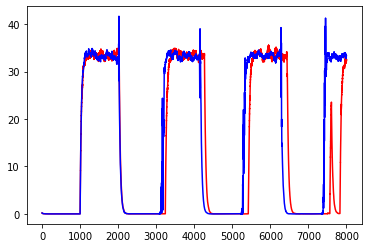

In [3]:
fig, ax1 = plt.subplots()

ax1.plot(tm,Mm,color="red")
ax1.plot(tl,Ml,color="blue")


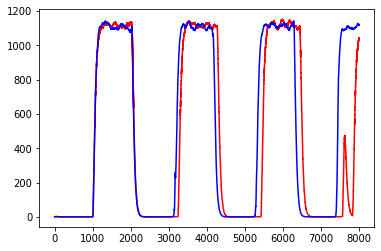

In [4]:
fig, ax1 = plt.subplots()

ax1.plot(tm,Pm,color="red")
ax1.plot(tl,Pl,color="blue")


In [5]:
np.std(spinter.interp1d(tm,Pm,kind="zero")(tl)),np.std(Pl)

(517.8490760622743, 527.961564109449)

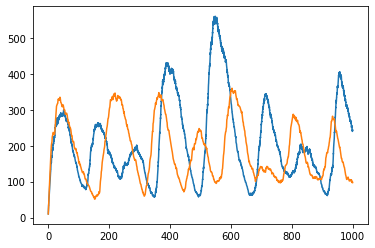

In [7]:
tm,Mm,Pm=master.one_trajectory(lambda_s=1,tau=18.5,P_0=100,h=5,T=1000)
tl,Ml,Pl=langevin.one_trajectory(lambda_s=1,tau=18.5,P_0=100,h=5,T=1000)

plt.plot(tm,Pm)
plt.plot(tl,Pl)


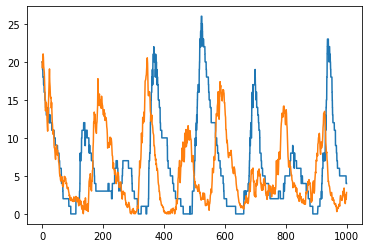

In [8]:
plt.plot(tm,Mm)
plt.plot(tl,Ml)

# Transient regime

## Research of the mean behaviour

In [9]:
n_iter=500
tl,table_M,table_P=langevin.multiple_trajectories(n_iter=n_iter,lambda_s=0.1,tau=25,P_0=1000,h=5,M_init=3,T=5000,delta_t=1,Omega=1)

Ml=np.mean(table_M,axis=0)
Pl=np.mean(table_P,axis=0)

_,power_spectrum_l=utils.compute_power_spectrum(tl,table_P)

In [10]:
n_iter=500
t_ref,table_M,table_P=master.multiple_trajectories(n_iter=n_iter,lambda_s=0.1,tau=25,P_0=1000,h=5,M_init=3,T=5000,Omega=1)

Mm=np.mean(table_M,axis=0)
Pm=np.mean(table_P,axis=0)

In [11]:
_,Mr,Pr=langevin.resolve_ODE(tau=18.5,P_0=1000,h=5,M_init=3,T=5000)

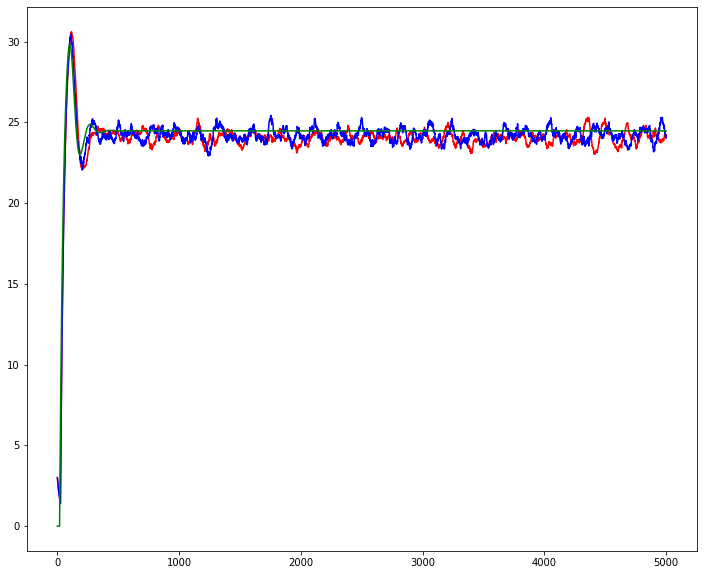

In [16]:
plt.figure(figsize=(12,10))
plt.plot(t_ref,Mm,color="red")
plt.plot(tl,Ml,color="blue")
plt.plot(tl,Mr,color="green")

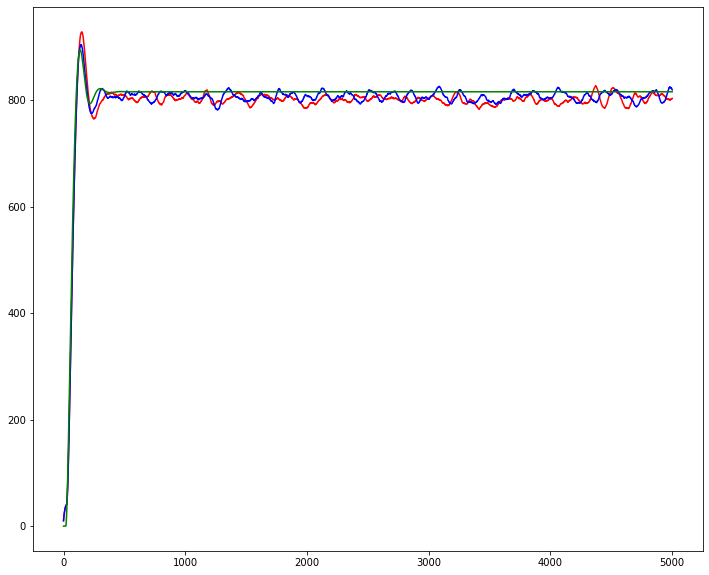

In [15]:
plt.figure(figsize=(12,10))
plt.plot(t_ref,Pm,color="red")
plt.plot(tl,Pl,color="blue")
plt.plot(tl,Pr,color="green")

## Comparison of M & P trajectories

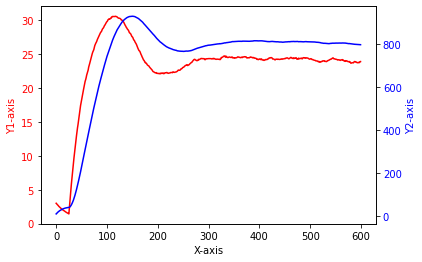

In [17]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Y1-axis', color = 'red') 
ax1.plot(t_ref[:600], Mm[:600], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Y2-axis', color = 'blue') 
ax2.plot(t_ref[:600], Pm[:600], color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# Show plot

plt.show()

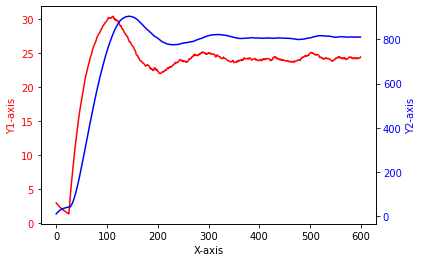

In [18]:
fig, ax1 = plt.subplots() 
  
ax1.set_xlabel('X-axis') 
ax1.set_ylabel('Y1-axis', color = 'red') 
ax1.plot(t_ref[:600], Ml[:600], color = 'red') 
ax1.tick_params(axis ='y', labelcolor = 'red') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Y2-axis', color = 'blue') 
ax2.plot(t_ref[:600], Pl[:600], color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
 
# Show plot

plt.show()

# Pooling values

## First tests, comparison of mean/std

In [19]:
pool_Ml,pool_Pl=langevin.pool_values(n_iter=100,tau=10,lambda_s=0.1,P_0=100,Omega=100)
pool_Mm,pool_Pm=master.pool_values(n_iter=100,tau=10,lambda_s=0.1,P_0=100,Omega=100)

In [20]:
print(np.mean(pool_Mm),np.mean(pool_Ml))
print(np.std(pool_Mm),np.std(pool_Ml))

5.3045648 5.215572064568942
3.1973358551458055 2.890790884789799


In [21]:
print(np.mean(pool_Pm),np.mean(pool_Pl))
print(np.std(pool_Pm),np.std(pool_Pl))

177.29585580000003 174.03821784664646
56.14254397919288 46.88473899625848


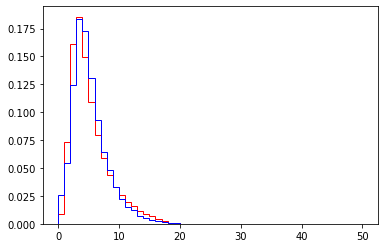

In [22]:
hist_Mm=plt.hist(pool_Mm,bins=50,range=(0,50),histtype='step',density=True,color='red')
hist_Ml=plt.hist(pool_Ml,bins=50,range=(0,50),histtype='step',density=True,color='blue')

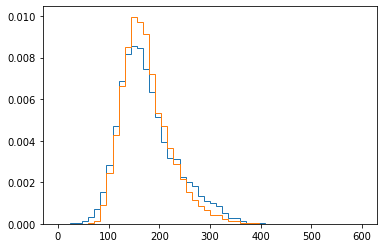

In [23]:
hist_Pm=plt.hist(pool_Pm,bins=50,range=(0,600),histtype='step',density=True)
hist_Pl=plt.hist(pool_Pl,bins=50,range=(0,600),histtype='step',density=True)

In [24]:
pool_Mm,pool_Pm=master.pool_values(n_iter=100,lambda_s=0.1,tau=18.5,P_0=100,h=5,M_init=3,P_init=5)
pool_Ml,pool_Pl=langevin.pool_values(n_iter=100,lambda_s=0.1,tau=18.5,P_0=100,h=5,M_init=3,P_init=5)


In [25]:
np.std(pool_Pm),np.std(pool_Pl)

(112.51616543060113, 91.44854874916223)

# Computation of power spectrum, mean, std depending on $\lambda$, $\Omega$, $\tau$

In [46]:
val_lambda=[0.01,0.1,1,10,100]
val_Omega=[1,10,100]
val_tau=[0.001,18.5,100]
n_lambda=np.size(val_lambda)
n_Omega=np.size(val_Omega)
n_tau=np.size(val_tau)

std_Mm=np.zeros((n_lambda,n_Omega,n_tau))
std_Ml=np.zeros((n_lambda,n_Omega,n_tau))

std_Pm=np.zeros((n_lambda,n_Omega,n_tau))
std_Pl=np.zeros((n_lambda,n_Omega,n_tau))

mean_Mm=np.zeros((n_lambda,n_Omega,n_tau))
mean_Ml=np.zeros((n_lambda,n_Omega,n_tau))

mean_Pm=np.zeros((n_lambda,n_Omega,n_tau))
mean_Pl=np.zeros((n_lambda,n_Omega,n_tau))

power_spectrum_Mm=np.zeros((n_lambda,n_Omega,n_tau),dtype=np.ndarray)
power_spectrum_Ml=np.zeros((n_lambda,n_Omega,n_tau),dtype=np.ndarray)

power_spectrum_Pm=np.zeros((n_lambda,n_Omega,n_tau),dtype=np.ndarray)
power_spectrum_Pl=np.zeros((n_lambda,n_Omega,n_tau),dtype=np.ndarray)


In [3]:
for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
            
            print("lambda=",val_lambda[i])
            print("Omega=",val_Omega[j])
            print("tau=",val_tau[k])
            
            output=utils.compute_fourier_transform_mean_and_std(n_iter=500,lambda_s=val_lambda[i],        
                                                      P_0=1000,
                                                      h=5,
                                                      tau=val_tau[k],
                                                      P_init=0,
                                                      M_init=0,
                                                      T=10000,
                                                      delta_t=1,
                                                      Omega=val_Omega[j])            
            
            t_ref=output["times"]
            omega_ref=output["frequencies"]
            
            std_Mm[i,j,k]=output["std Mm"]
            std_Ml[i,j,k]=output["std Ml"]

            std_Pm[i,j,k]=output["std Pm"]
            std_Pl[i,j,k]=output["std Pl"]

            mean_Mm[i,j,k]=output["mean Mm"]
            mean_Ml[i,j,k]=output["mean Ml"]

            mean_Pm[i,j,k]=output["mean Pm"]
            mean_Pl[i,j,k]=output["mean Pl"]

            power_spectrum_Mm[i,j,k]=output["power spectrum Mm"]
            power_spectrum_Ml[i,j,k]=output["power spectrum Ml"]
            
            power_spectrum_Pm[i,j,k]=output["power spectrum Pm"]
            power_spectrum_Pl[i,j,k]=output["power spectrum Pl"]

            print("Done")
            print("\n")
        

lambda= 0.01
Omega= 1
tau= 0.001
Done


lambda= 0.01
Omega= 1
tau= 18.5
Done


lambda= 0.01
Omega= 1
tau= 100
Done


lambda= 0.01
Omega= 10
tau= 0.001
Done


lambda= 0.01
Omega= 10
tau= 18.5
Done


lambda= 0.01
Omega= 10
tau= 100
Done


lambda= 0.01
Omega= 100
tau= 0.001
Done


lambda= 0.01
Omega= 100
tau= 18.5
Done


lambda= 0.01
Omega= 100
tau= 100
Done


lambda= 0.1
Omega= 1
tau= 0.001
Done


lambda= 0.1
Omega= 1
tau= 18.5
Done


lambda= 0.1
Omega= 1
tau= 100
Done


lambda= 0.1
Omega= 10
tau= 0.001
Done


lambda= 0.1
Omega= 10
tau= 18.5
Done


lambda= 0.1
Omega= 10
tau= 100
Done


lambda= 0.1
Omega= 100
tau= 0.001
Done


lambda= 0.1
Omega= 100
tau= 18.5
Done


lambda= 0.1
Omega= 100
tau= 100
Done


lambda= 1
Omega= 1
tau= 0.001
Done


lambda= 1
Omega= 1
tau= 18.5
Done


lambda= 1
Omega= 1
tau= 100
Done


lambda= 1
Omega= 10
tau= 0.001
Done


lambda= 1
Omega= 10
tau= 18.5
Done


lambda= 1
Omega= 10
tau= 100
Done


lambda= 1
Omega= 100
tau= 0.001
Done


lambda= 1
Omega= 100
tau= 18.5


In [88]:
current_directory = os.getcwd()
new_directory = current_directory + '\\output'

if not os.path.exists(new_directory):
    os.makedirs(new_directory)
    os.makedirs(new_directory+'\\data')
    os.makedirs(new_directory+'\\plots')

In [71]:
t_ref=[1,2,3]

pd.DataFrame(t_ref,columns=['value']).to_csv('output/data/times.csv')
pd.DataFrame(omega_ref,columns=['value']).to_csv('output/data/freq.csv')

pd.DataFrame(std_Mm,columns=['value']).to_csv('output/data/std_Mm.csv')
pd.DataFrame(std_Ml,columns=['value']).to_csv('output/data/std_Ml.csv')
pd.DataFrame(std_Pm,columns=['value']).to_csv('output/data/std_Pm.csv')
pd.DataFrame(std_Pl,columns=['value']).to_csv('output/data/std_Pl.csv')

pd.DataFrame(mean_Mm,columns=['value']).to_csv('output/data/mean_Mm.csv')
pd.DataFrame(mean_Ml,columns=['value']).to_csv('output/data/mean_Ml.csv')
pd.DataFrame(mean_Pm,columns=['value']).to_csv('output/data/mean_Pm.csv')
pd.DataFrame(mean_Pl,columns=['value']).to_csv('output/data/mean_Pl.csv')

pd.DataFrame(power_spectrum_Mm,columns=['value']).to_csv('output/data/power_spectrum_Mm.csv')
pd.DataFrame(power_spectrum_Ml,columns=['value']).to_csv('output/data/power_spectrum_Ml.csv')
pd.DataFrame(power_spectrum_Pm,columns=['value']).to_csv('output/data/power_spectrum_Pm.csv')
pd.DataFrame(power_spectrum_Pl,columns=['value']).to_csv('output/data/power_spectrum_Pl.csv')

NameError: name 'omega_ref' is not defined

In [70]:
t_ref=pd.read_csv('output/data/times.csv')['value'].values.tolist()
omega_ref=pd.read_csv('output/data/freq.csv')['value'].values.tolist()

std_Mm=pd.read_csv('output/data/std_Mm.csv')['value'].values.tolist()
std_Ml=pd.read_csv('output/data/std_Ml.csv')['value'].values.tolist()
std_Pm=pd.read_csv('output/data/std_Pm.csv')['value'].values.tolist()
std_Pl=pd.read_csv('output/data/std_Pl.csv')['value'].values.tolist()

mean_Mm=pd.read_csv('output/data/mean_Mm.csv')['value'].values.tolist()
mean_Ml=pd.read_csv('output/data/mean_Ml.csv')['value'].values.tolist()
mean_Pm=pd.read_csv('output/data/mean_Pm.csv')['value'].values.tolist()
mean_Pl=pd.read_csv('output/data/mean_Pl.csv')['value'].values.tolist()

power_spectrum_Mm=pd.read_csv('output/data/power_spectrum_Mm.csv')['value'].values.tolist()
power_spectrum_Ml=pd.read_csv('output/data/power_spectrum_Ml.csv')['value'].values.tolist()
power_spectrum_Pm=pd.read_csv('output/data/power_spectrum_Pm.csv')['value'].values.tolist()
power_spectrum_Pl=pd.read_csv('output/data/power_spectrum_Pl.csv')['value'].values.tolist()

FileNotFoundError: [Errno 2] No such file or directory: 'output/freq.csv'

### Plot mean

In [47]:
alpha_m=1
alpha_p=1
mu_m=0.03
mu_p=0.03
h=5
P_0=1000
T=10000
delta_t=1

n_t=int(T/delta_t)//2

M_stat_mean=np.zeros(n_tau)
P_stat_mean=np.zeros(n_tau)

for i in range(n_tau):
    t_00,M_ODE,P_ODE=langevin.resolve_ODE(h=h, P_0 = P_0, T=T, tau=val_tau[i] )
    M_stat_mean[i]=np.mean(M_ODE[n_t:])
    P_stat_mean[i]=np.mean(P_ODE[n_t:])

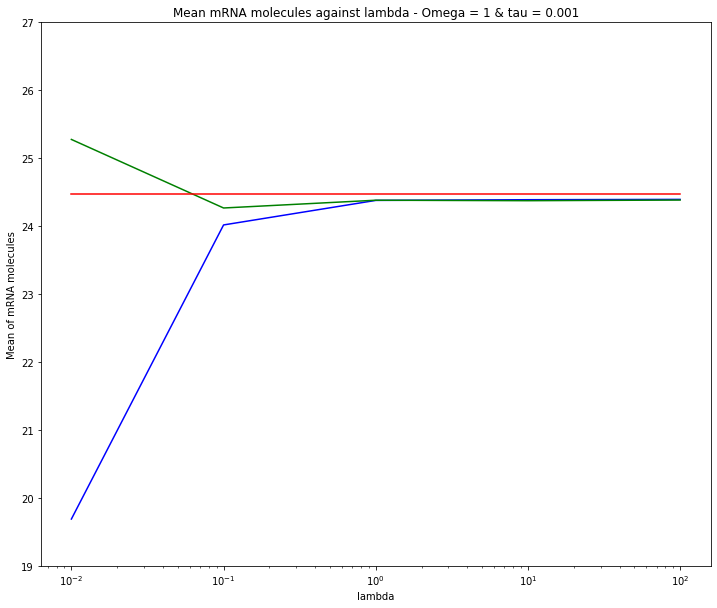

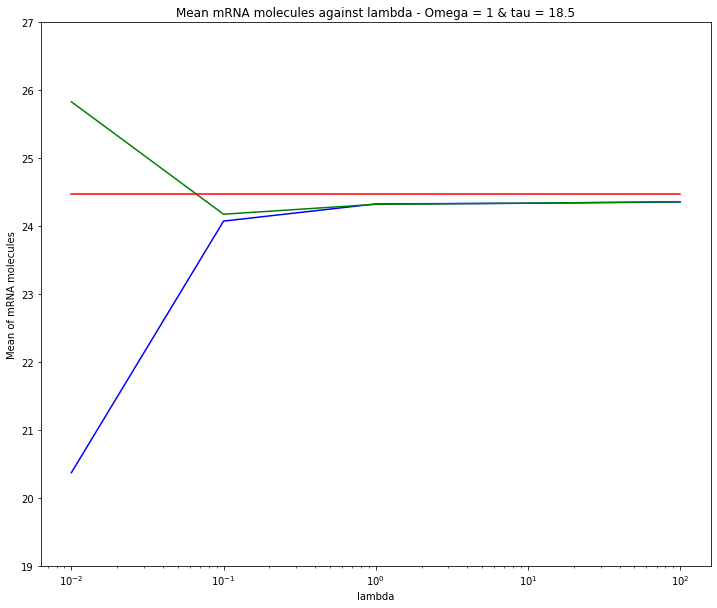

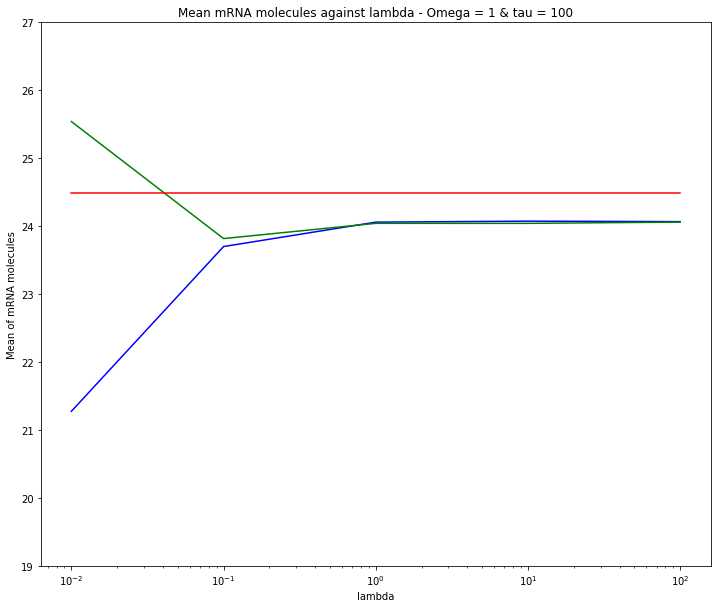

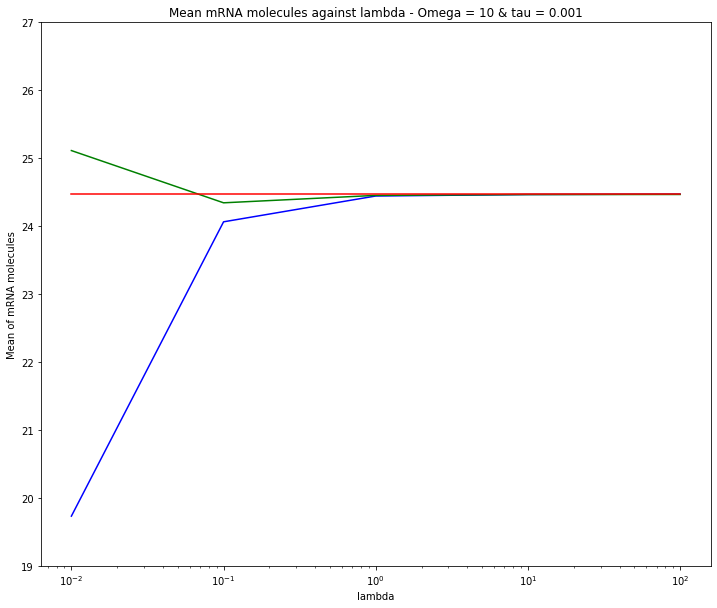

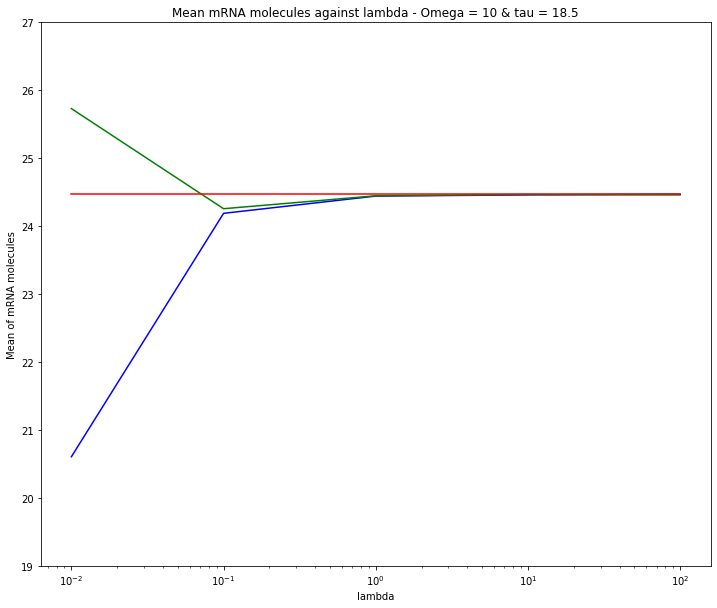

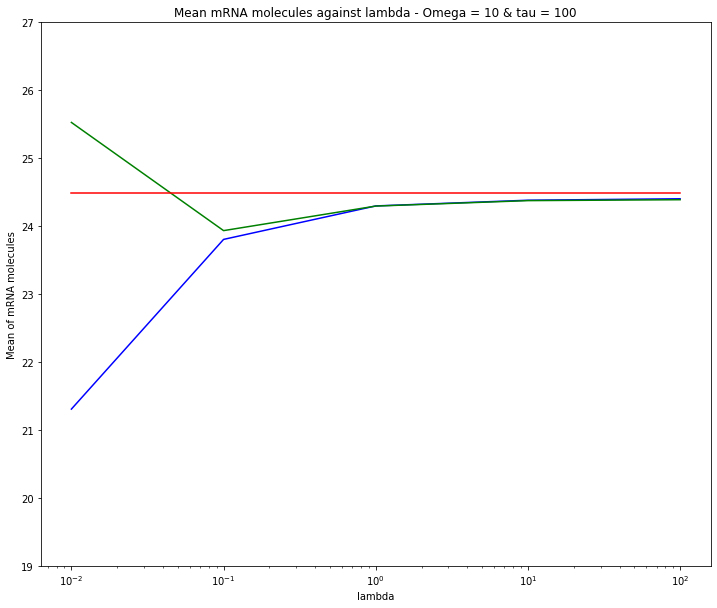

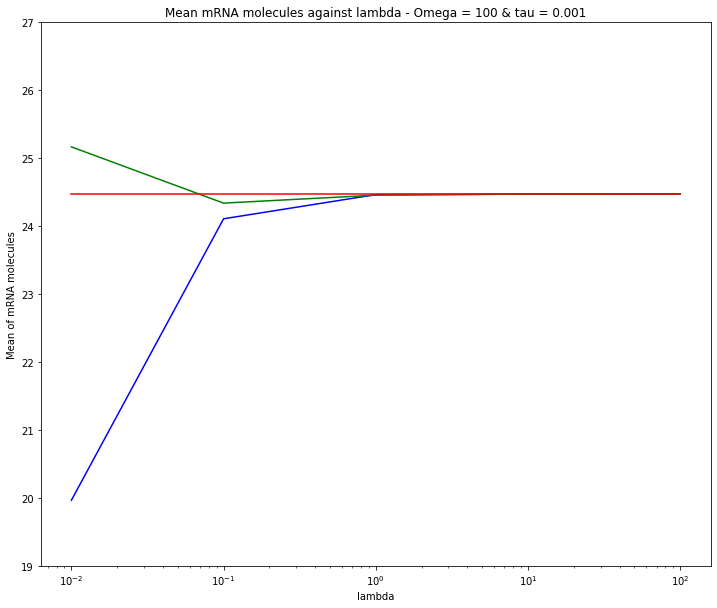

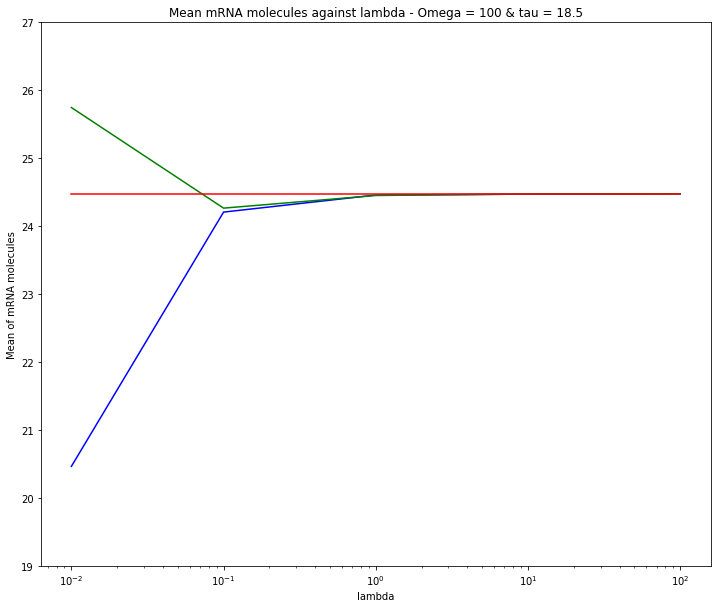

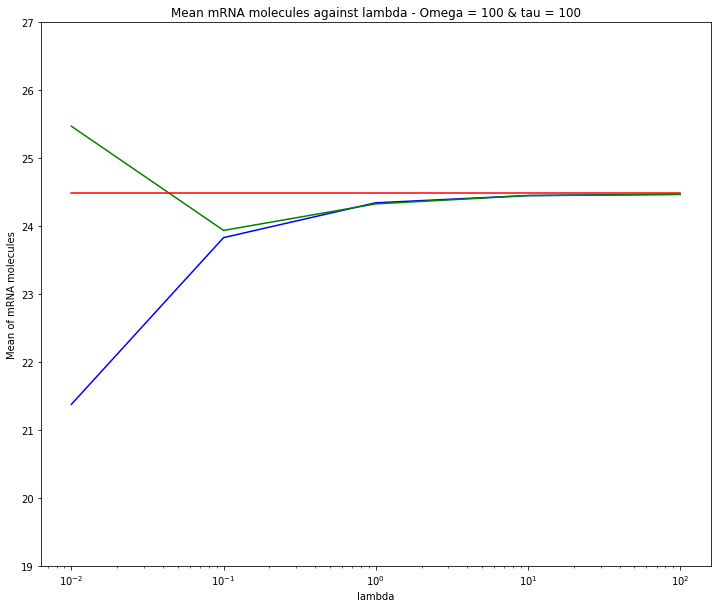

In [81]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        #print('Omega=',val_Omega[j])
        #print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 
        
        ax1.set_title('Mean mRNA molecules against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('Mean of mRNA molecules') 
        
        ax1.plot(val_lambda, mean_Mm[:,j,k], color = 'blue') 
        ax1.plot(val_lambda, mean_Ml[:,j,k], color = 'green')
        ax1.plot(val_lambda, n_lambda*[M_stat_mean[k]], color='red')

        
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        
        #ax1.set_xlim(0.001,100)
        ax1.set_ylim(19,27)
        
        plt.savefig('plots/mean_M/plot_mean_M - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  
        
        plt.show()

Omega= 1
tau= 0.001


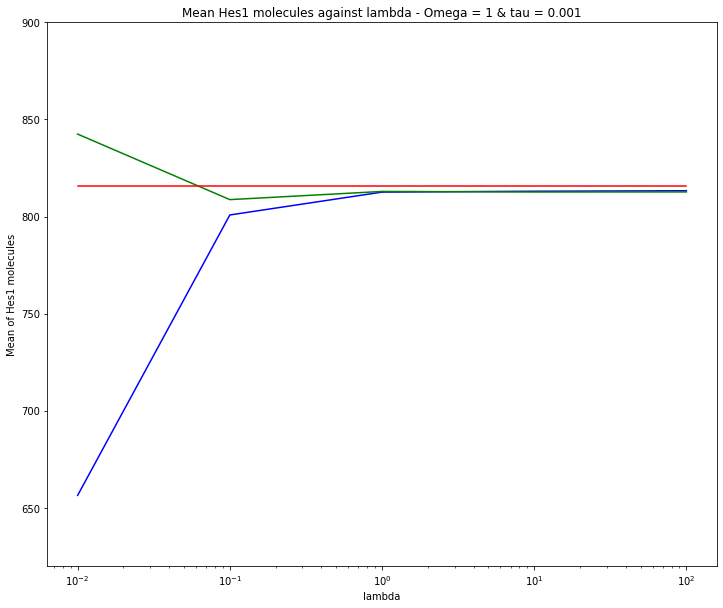

Omega= 1
tau= 18.5


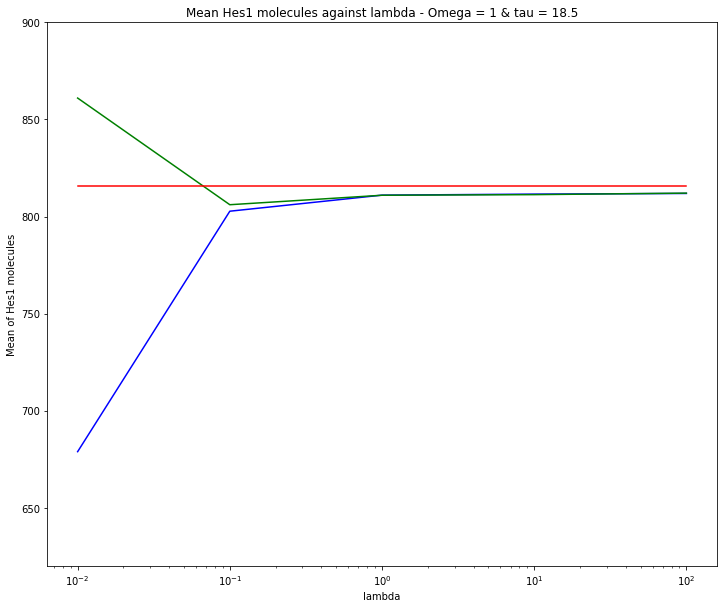

Omega= 1
tau= 100


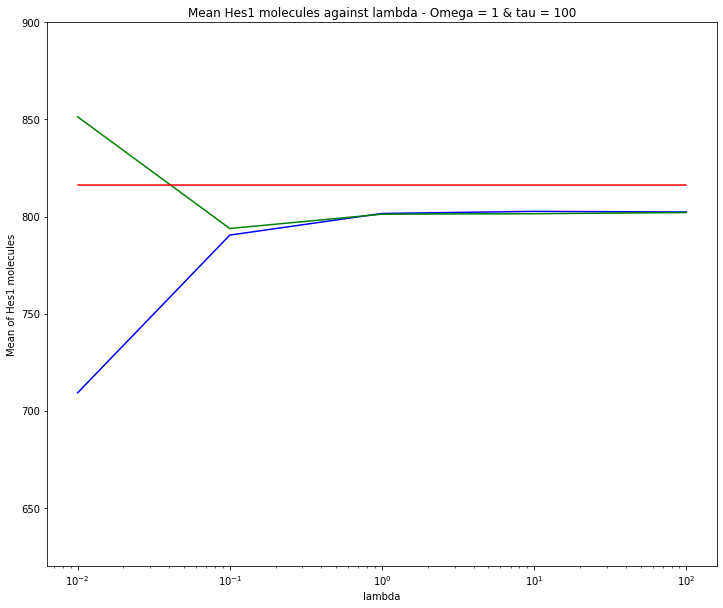

Omega= 10
tau= 0.001


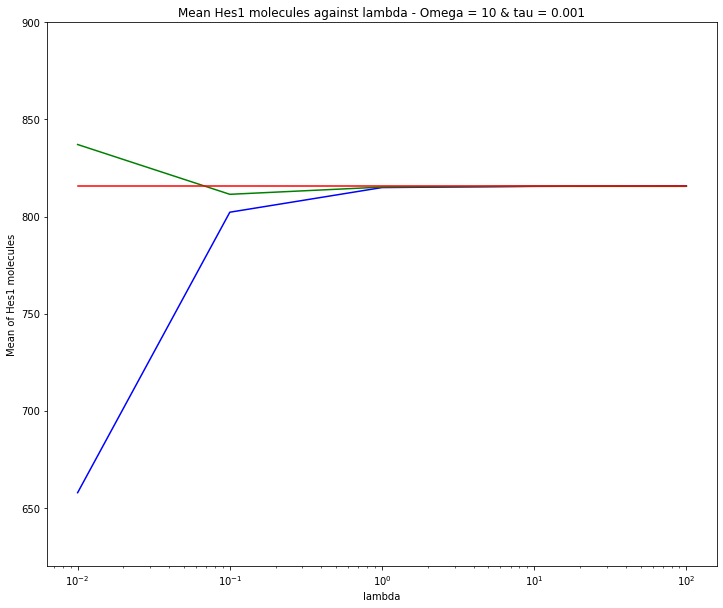

Omega= 10
tau= 18.5


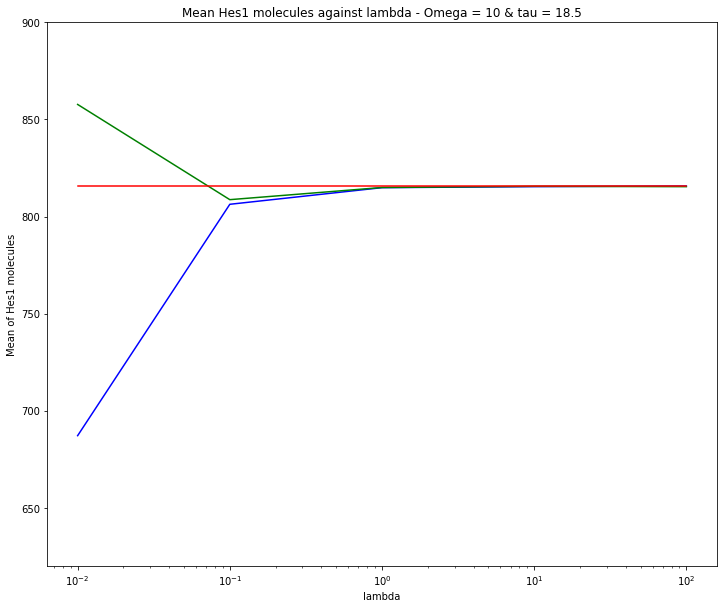

Omega= 10
tau= 100


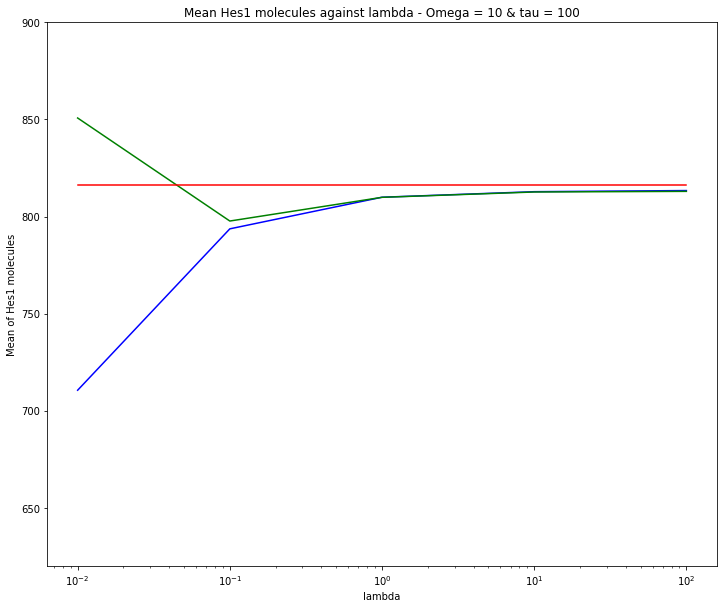

Omega= 100
tau= 0.001


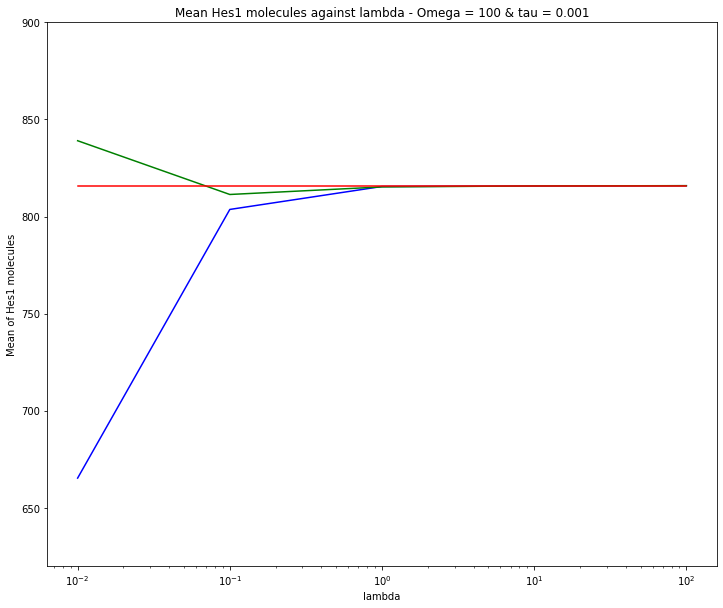

Omega= 100
tau= 18.5


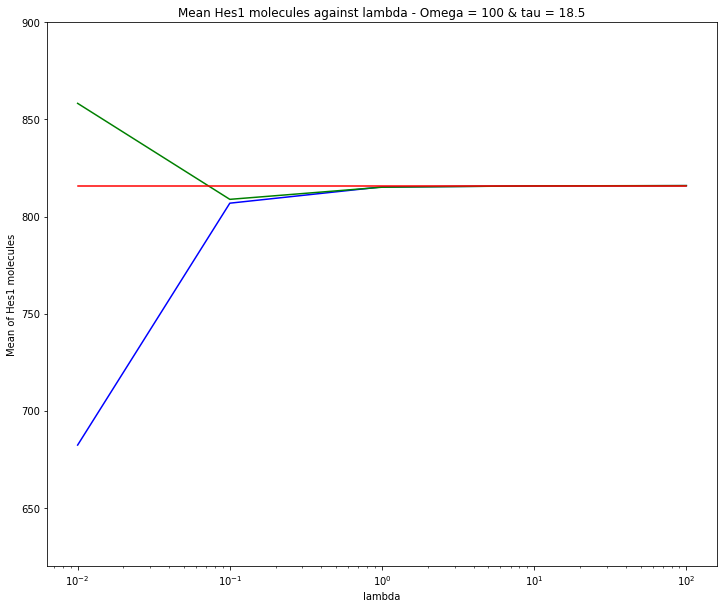

Omega= 100
tau= 100


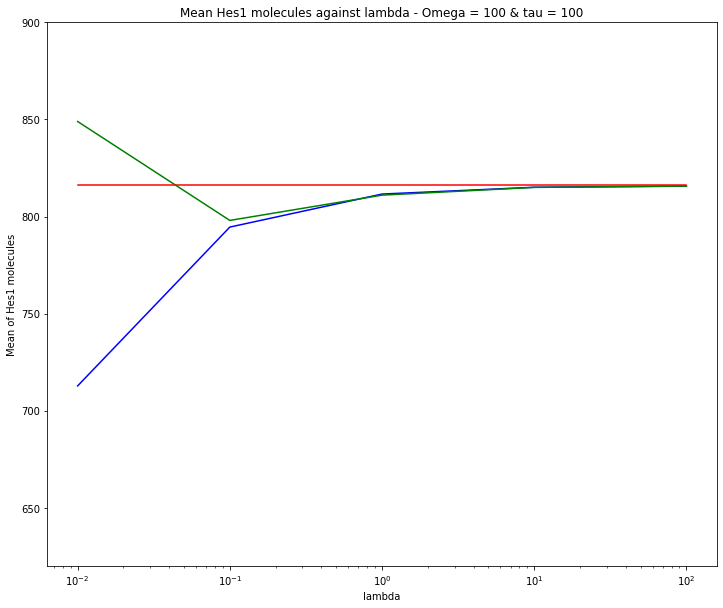

In [82]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        print('Omega=',val_Omega[j])
        print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 

        ax1.set_title('Mean Hes1 molecules against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('Mean of Hes1 molecules') 
        ax1.plot(val_lambda, mean_Pm[:,j,k], color = 'blue') 
        ax1.plot(val_lambda, mean_Pl[:,j,k], color = 'green')
        ax1.plot(val_lambda, n_lambda*[P_stat_mean[k]], color='red')

        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_ylim(620,900)

        
        plt.savefig('plots/mean_P/plot_mean_P - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

        plt.show()

### Plot std

#### Plot std against $\lambda$

In [83]:
std_th_M=np.zeros((n_lambda,n_Omega,n_tau))
std_th_P=np.zeros((n_lambda,n_Omega,n_tau))

for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
            omega_th,Sm,Sp=utils.lna_power_spectrum(lambda_s=val_lambda[i],P_0=1000,tau=val_tau[k],Omega=val_Omega[j],T=T,delta_t=1)
            delta_omega = omega_th[1]-omega_th[0]
            std_th_M[i,j,k] = np.sqrt(n_t*sum(Sm)*delta_omega)
            std_th_P[i,j,k] = np.sqrt(n_t*sum(Sp)*delta_omega)

Omega= 1
tau= 0.001


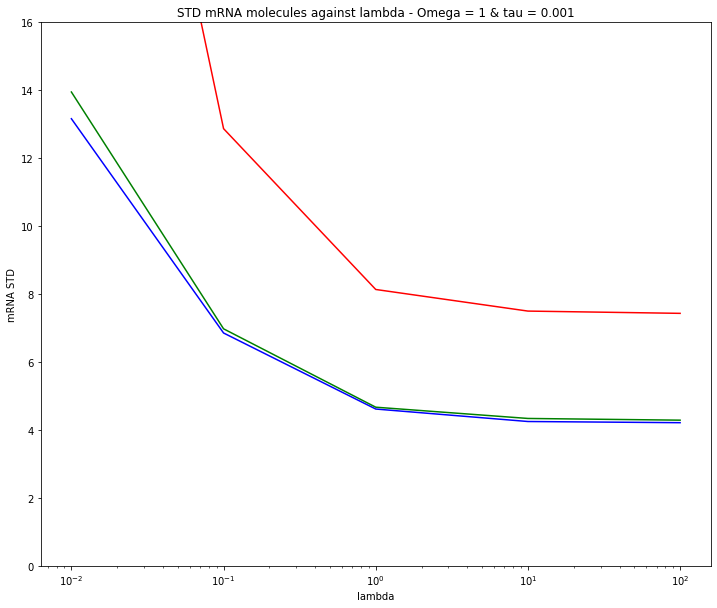

Omega= 1
tau= 18.5


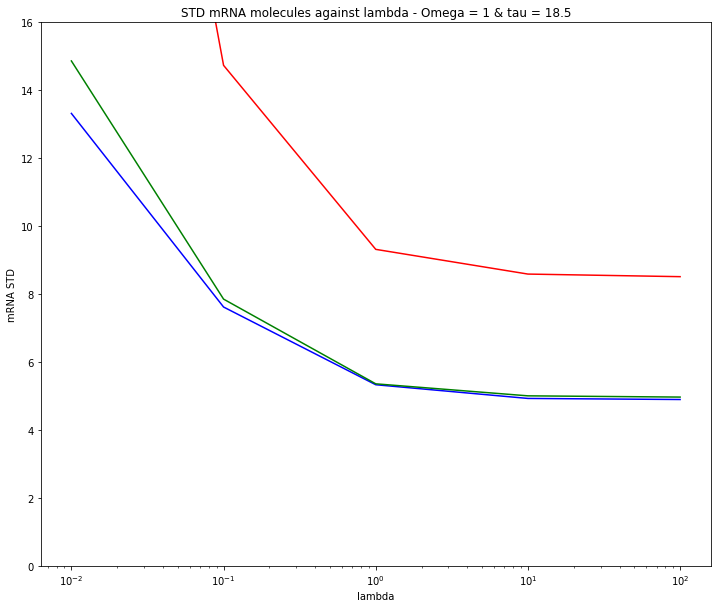

Omega= 1
tau= 100


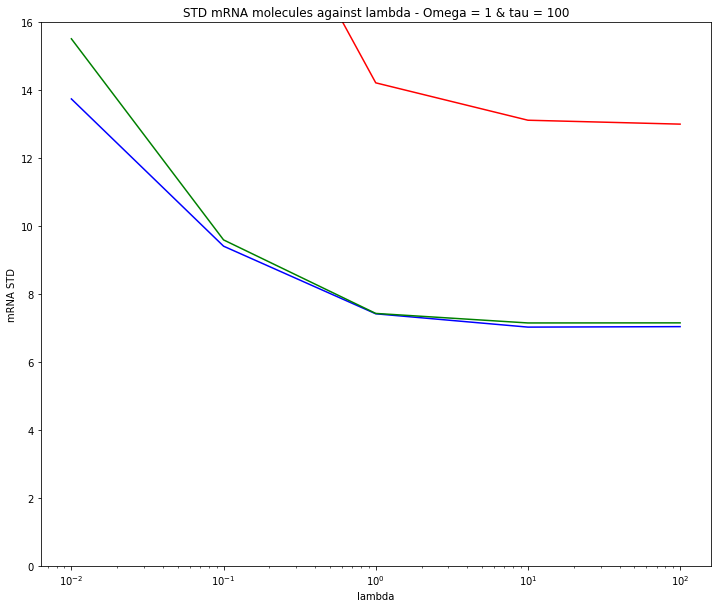

Omega= 10
tau= 0.001


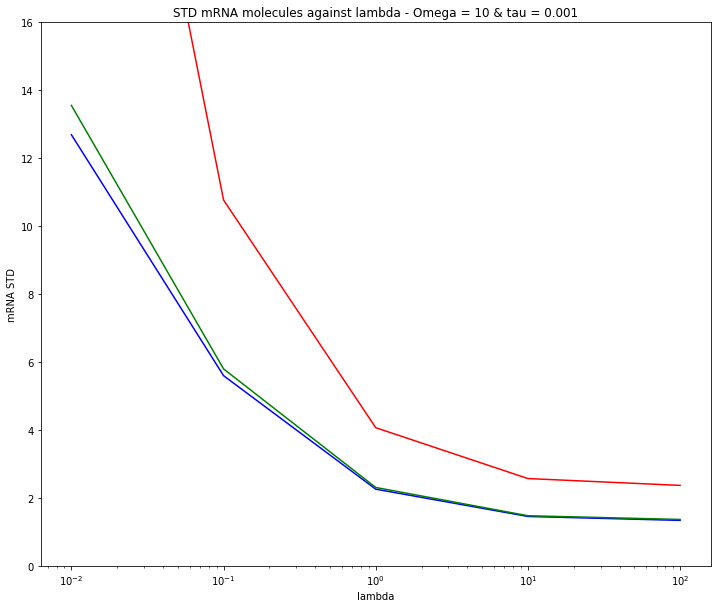

Omega= 10
tau= 18.5


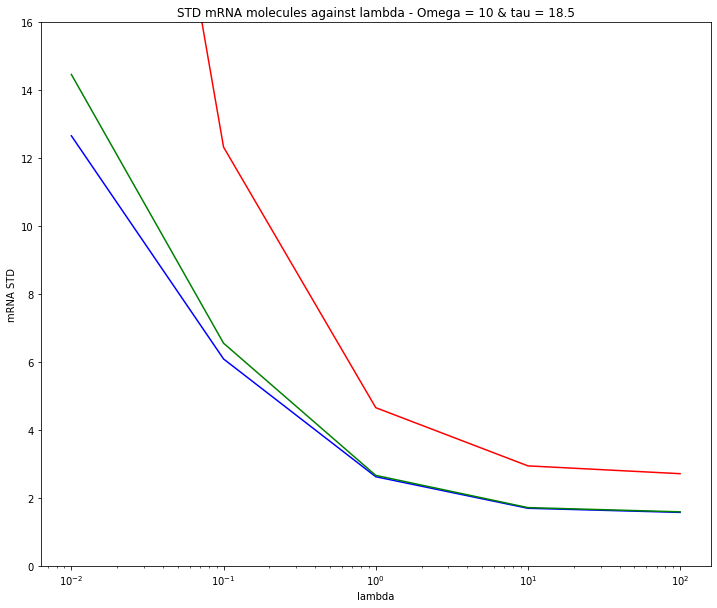

Omega= 10
tau= 100


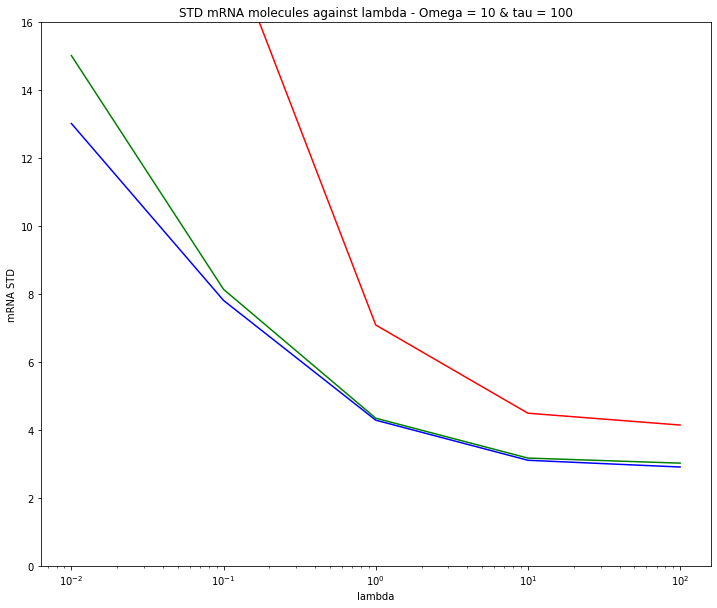

Omega= 100
tau= 0.001


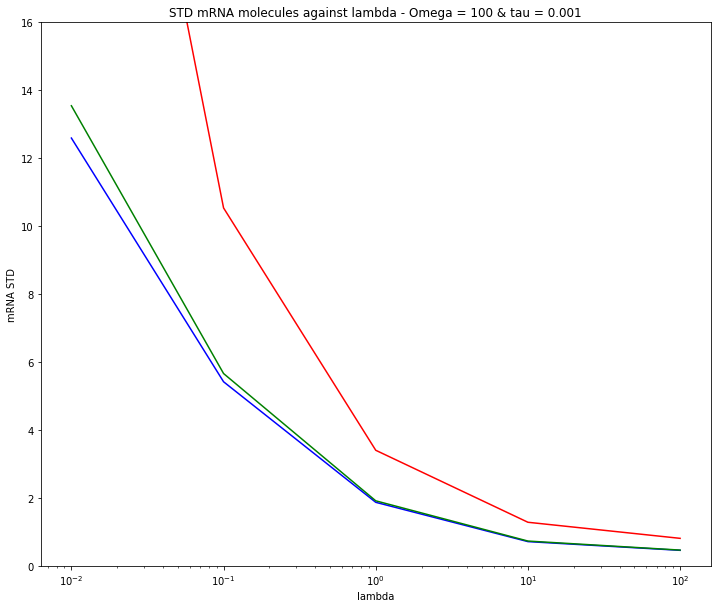

Omega= 100
tau= 18.5


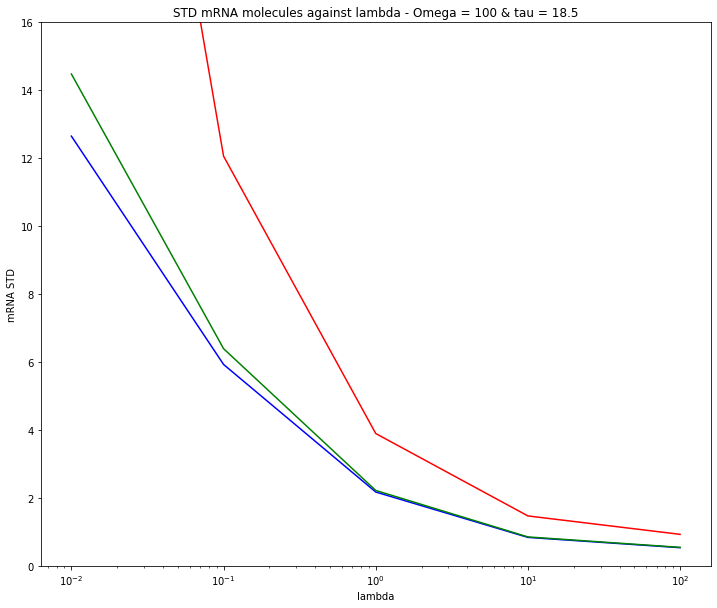

Omega= 100
tau= 100


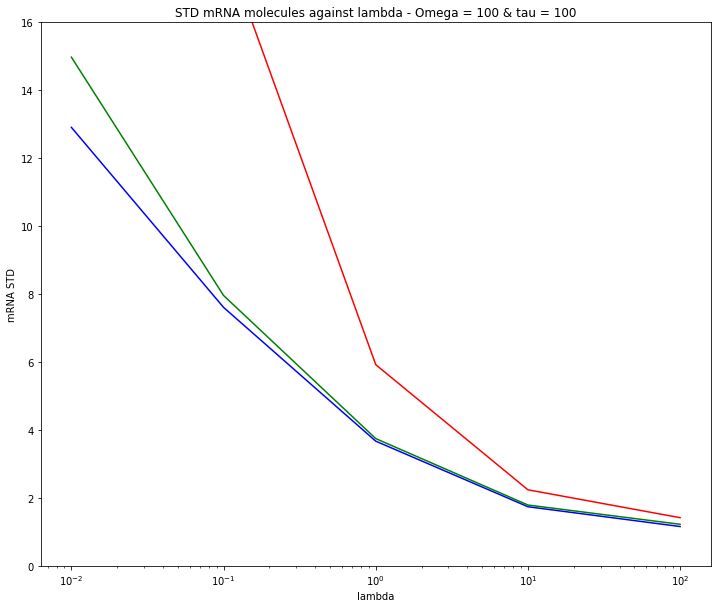

In [85]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        print('Omega=',val_Omega[j])
        print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 

        ax1.set_title('STD mRNA molecules against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('mRNA STD')  
        
        ax1.plot(val_lambda, std_Mm[:,j,k], color = 'blue') 
        ax1.plot(val_lambda, std_Ml[:,j,k], color = 'green')
        ax1.plot(val_lambda, std_th_M[:,j,k], color = 'red')
        
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_ylim(0,16)

        plt.savefig('plots/std_M/plot_std_M - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

        plt.show()

Omega= 1
tau= 0.001


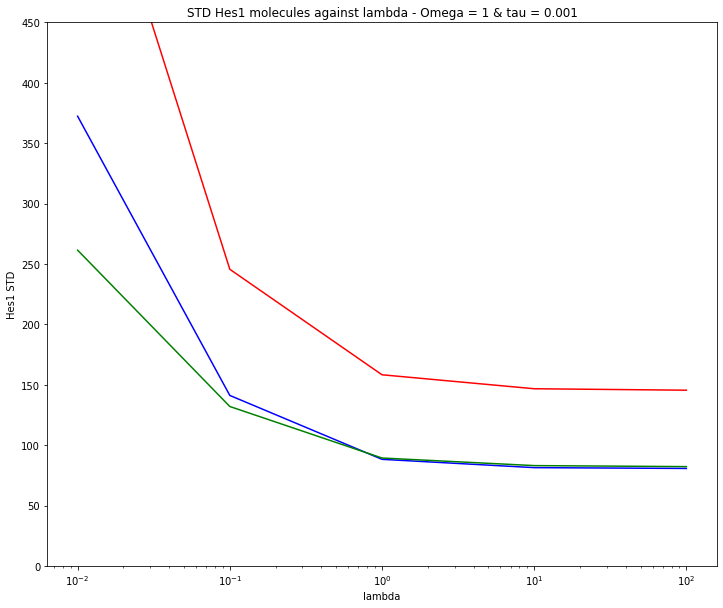

Omega= 1
tau= 18.5


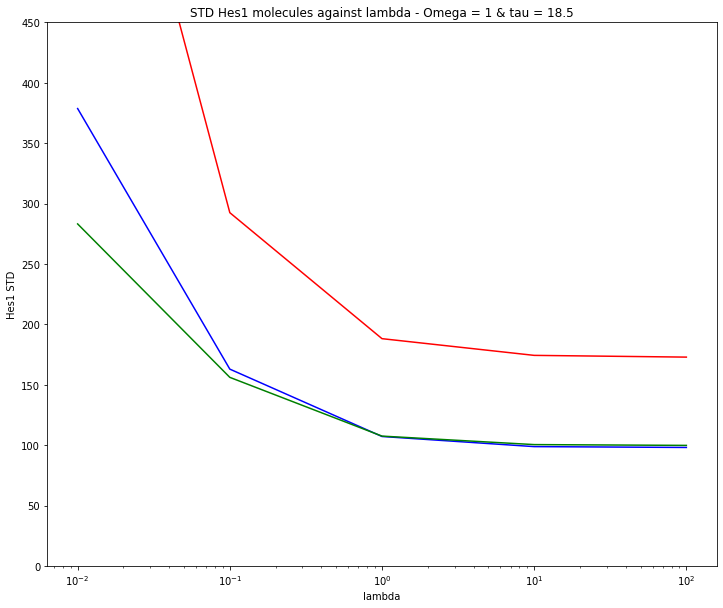

Omega= 1
tau= 100


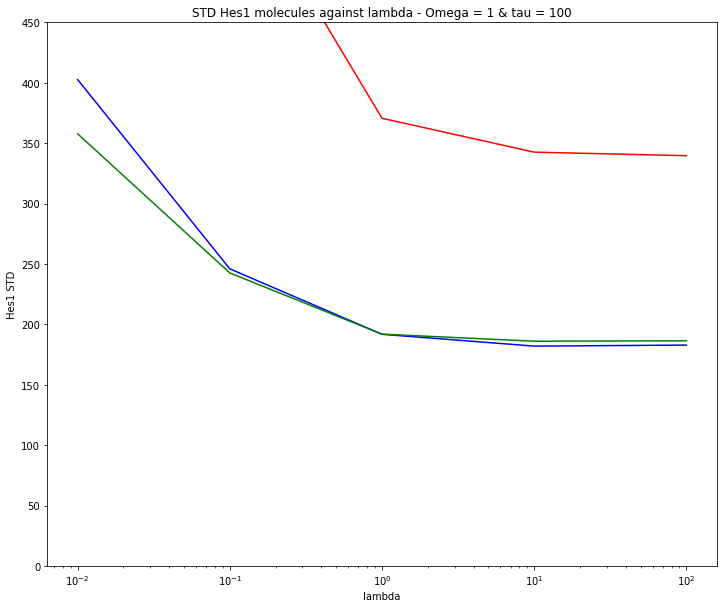

Omega= 10
tau= 0.001


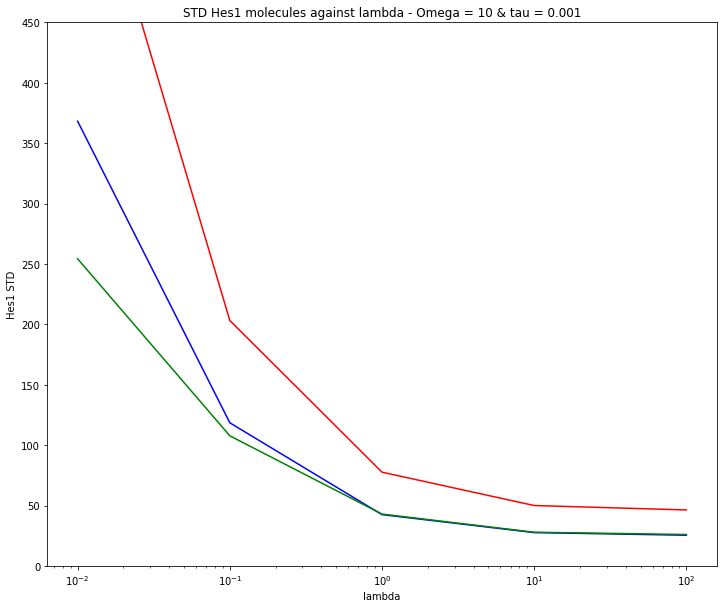

Omega= 10
tau= 18.5


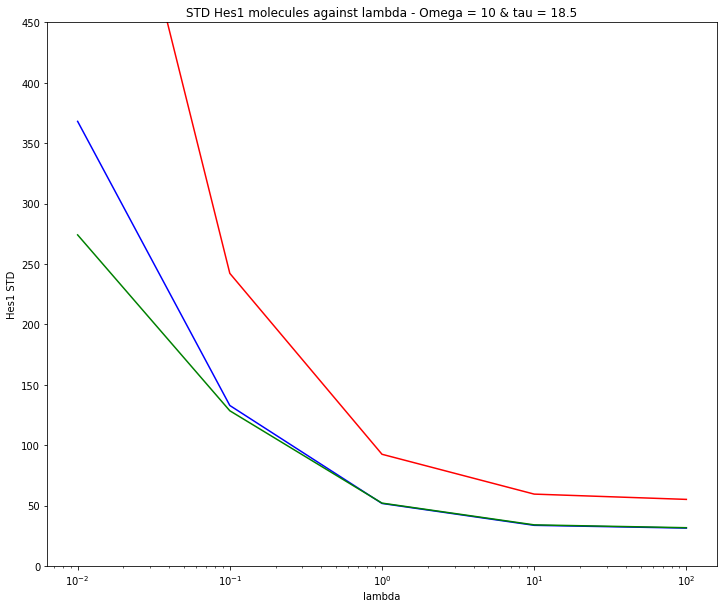

Omega= 10
tau= 100


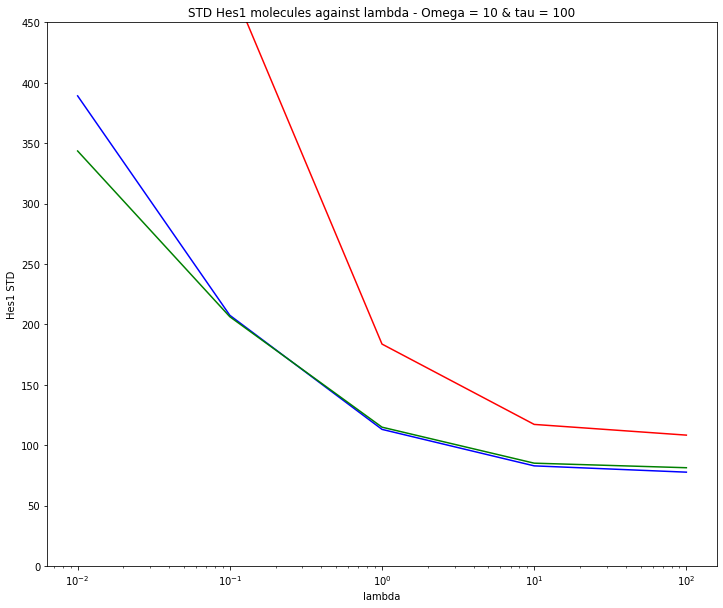

Omega= 100
tau= 0.001


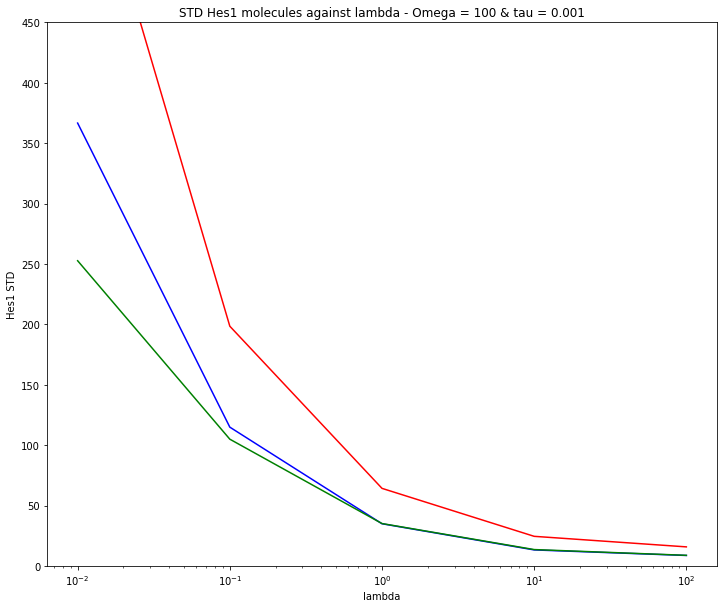

Omega= 100
tau= 18.5


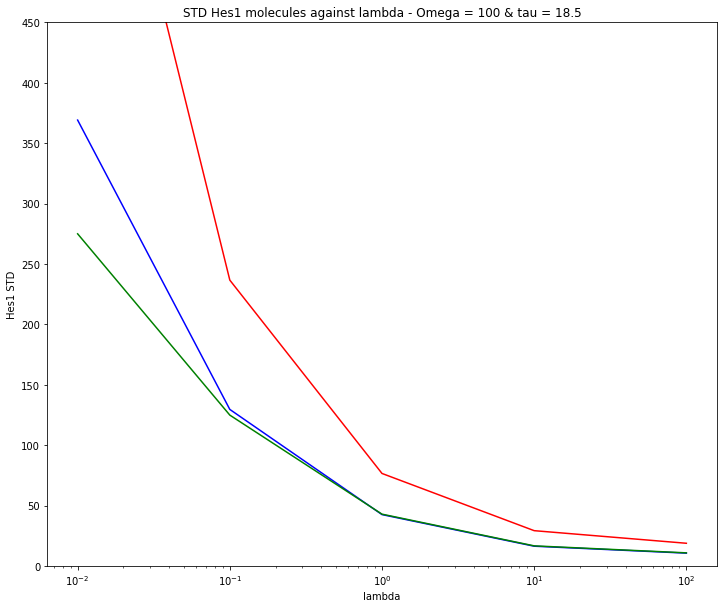

Omega= 100
tau= 100


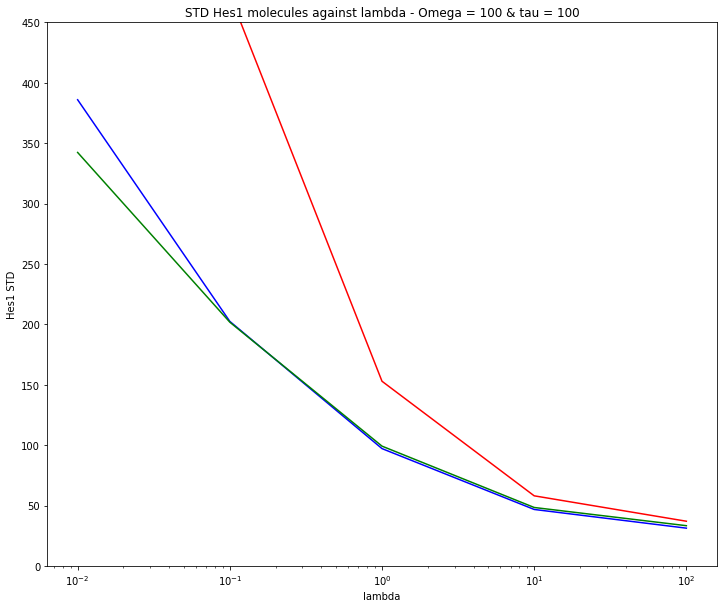

In [86]:
for j in range(n_Omega):
    for k in range(n_tau):
    
        print('Omega=',val_Omega[j])
        print('tau=',val_tau[k])
        fig, ax1 = plt.subplots(figsize=(12,10)) 

        ax1.set_title('STD Hes1 molecules against lambda - Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('lambda') 
        ax1.set_ylabel('Hes1 STD') 
        
        ax1.plot(val_lambda, std_Pm[:,j,k], color = 'blue') 
        ax1.plot(val_lambda, std_Pl[:,j,k], color = 'green')
        ax1.plot(val_lambda, std_th_P[:,j,k], color = 'red')
        
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_ylim(0,450)
        
        plt.savefig('plots/std_P/plot_std_P - Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

        plt.show()

#### Plot level curves of std against $\lambda$ and $\Omega$

tau= 0.001


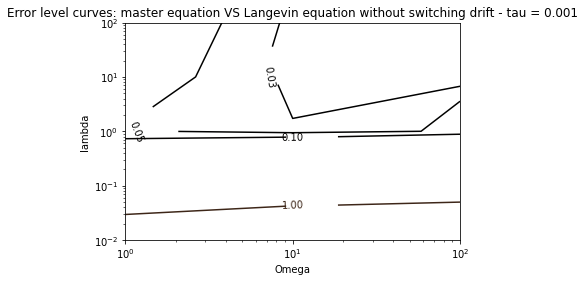

tau= 18.5


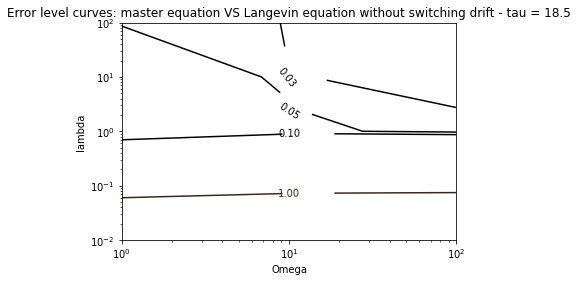

tau= 100


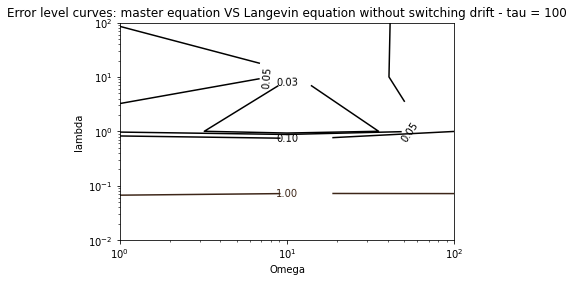

In [28]:
levels=[0.03, 0.05, 0.1, 1, 5]

for k in range(n_tau):
    
        print('tau=',val_tau[k])
        
        fig, ax1 = plt.subplots() 
        ax1.set_title('Error level curves: master equation VS Langevin equation without switching drift - tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('Omega') 
        ax1.set_ylabel('lambda') 
        contours1=ax1.contour(val_Omega, val_lambda, abs(std_Mm[:,:,k] - std_Ml[:,:,k]), cmap = 'copper', levels=levels)
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.clabel(contours1,inline=1, fontsize=10)
        plt.savefig('plot_level_curve_std_Mm_vs_Ml - tau' + str(val_tau[k]) + '.pdf')
        plt.show()

tau= 0.001


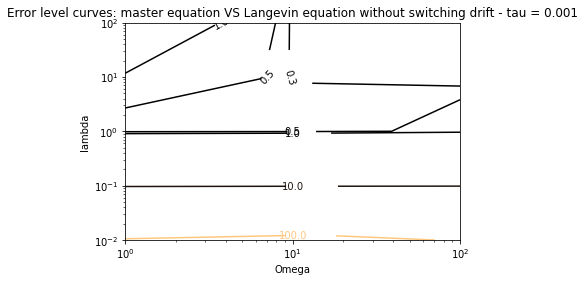

tau= 18.5


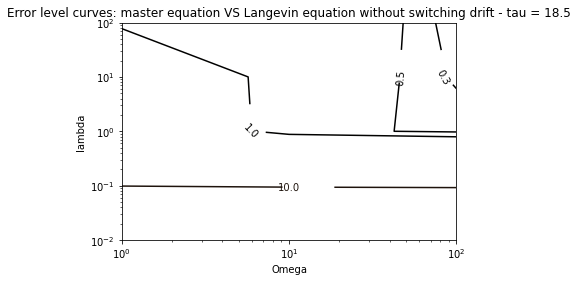

tau= 100


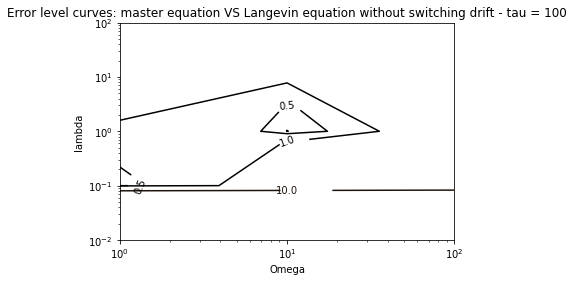

In [29]:
levels=[0.3, 0.5, 1, 10, 100]

for k in range(n_tau):
    
        print('tau=',val_tau[k])
        
        fig, ax1 = plt.subplots() 
        ax1.set_title('Error level curves: master equation VS Langevin equation without switching drift - tau = ' + str(val_tau[k])) 
        ax1.set_xlabel('Omega') 
        ax1.set_ylabel('lambda') 
        contours1=ax1.contour(val_Omega, val_lambda, abs(std_Pm[:,:,k] - std_Pl[:,:,k]), cmap = 'copper', levels=levels)
        ax1.tick_params(axis ='y') 
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.clabel(contours1,inline=1, fontsize=10)
        plt.savefig('plot_level_curve_std_Pm_vs_Pl - tau' + str(val_tau[k]) + '.pdf')
        plt.show()
        

#### Plot power spectra

lambda= 0.01
Omega= 1
tau= 0.001


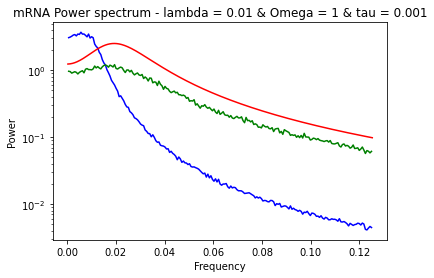

lambda= 0.01
Omega= 1
tau= 18.5


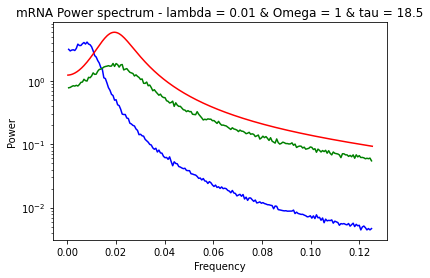

lambda= 0.01
Omega= 1
tau= 100


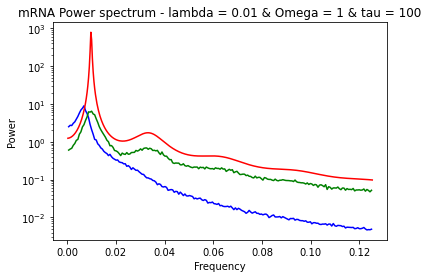

lambda= 0.01
Omega= 10
tau= 0.001


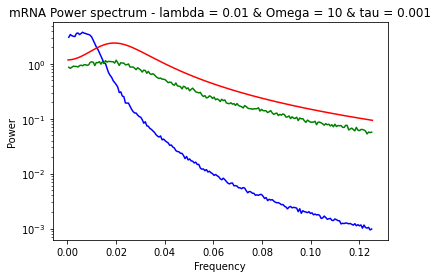

lambda= 0.01
Omega= 10
tau= 18.5


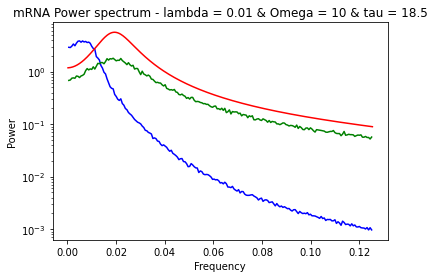

lambda= 0.01
Omega= 10
tau= 100


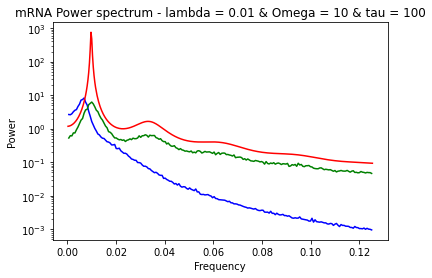

lambda= 0.01
Omega= 100
tau= 0.001


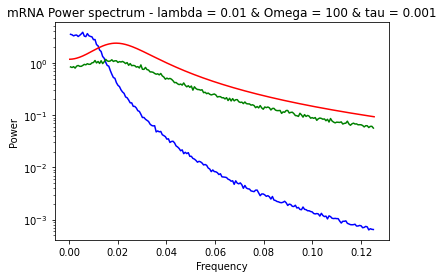

lambda= 0.01
Omega= 100
tau= 18.5


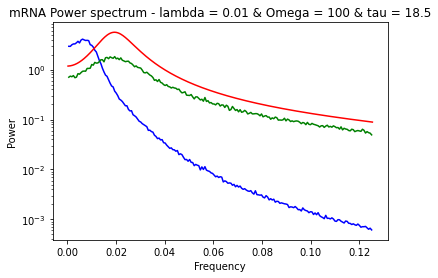

lambda= 0.01
Omega= 100
tau= 100


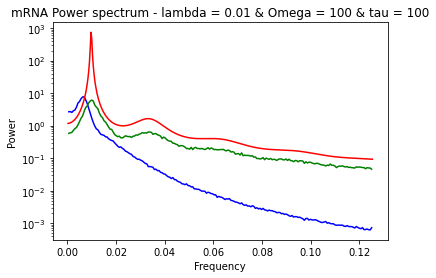

lambda= 0.1
Omega= 1
tau= 0.001


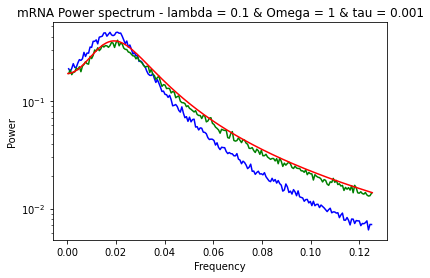

lambda= 0.1
Omega= 1
tau= 18.5


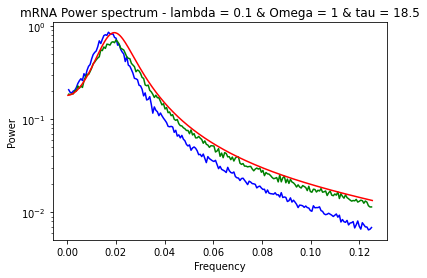

lambda= 0.1
Omega= 1
tau= 100


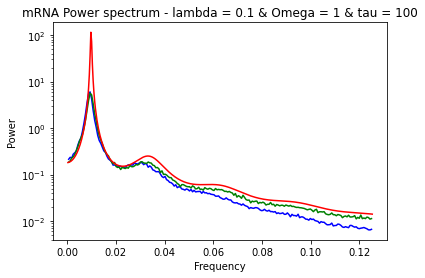

lambda= 0.1
Omega= 10
tau= 0.001


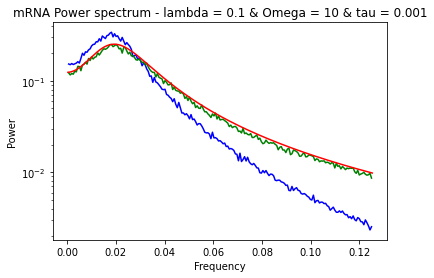

lambda= 0.1
Omega= 10
tau= 18.5


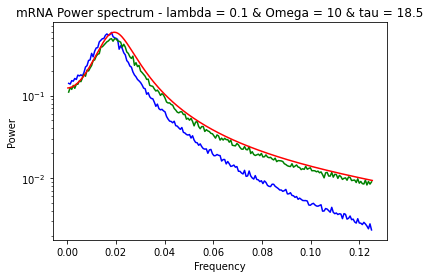

lambda= 0.1
Omega= 10
tau= 100


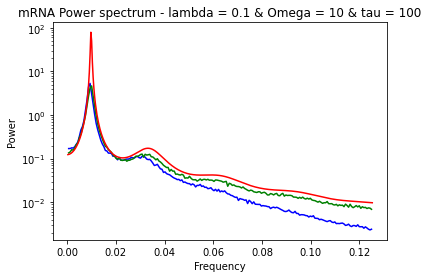

lambda= 0.1
Omega= 100
tau= 0.001


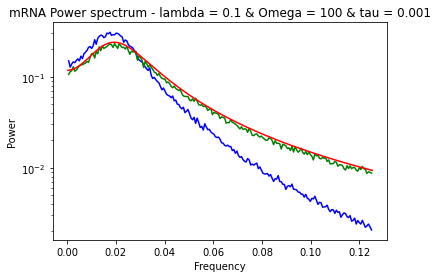

lambda= 0.1
Omega= 100
tau= 18.5


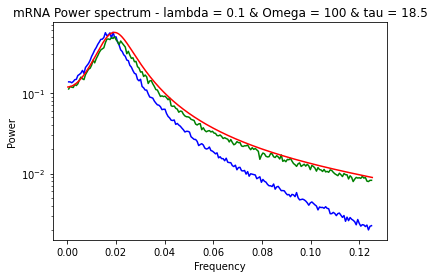

lambda= 0.1
Omega= 100
tau= 100


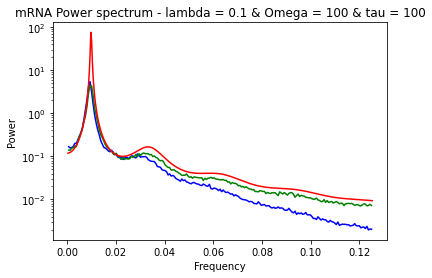

lambda= 1
Omega= 1
tau= 0.001


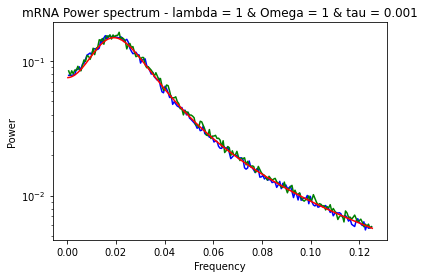

lambda= 1
Omega= 1
tau= 18.5


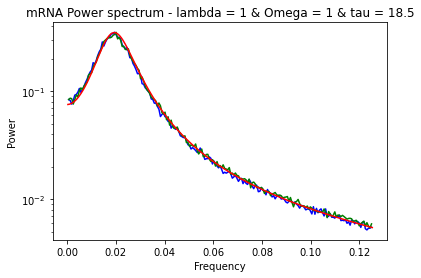

lambda= 1
Omega= 1
tau= 100


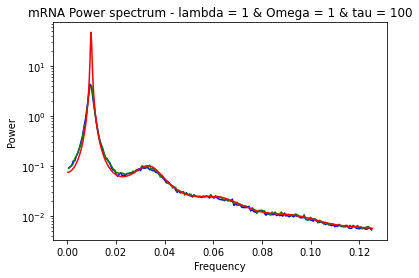

lambda= 1
Omega= 10
tau= 0.001


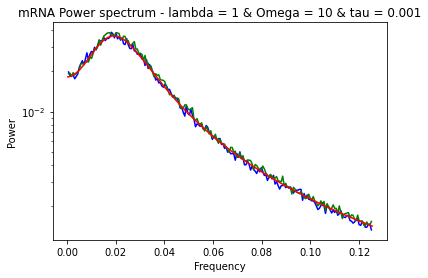

lambda= 1
Omega= 10
tau= 18.5


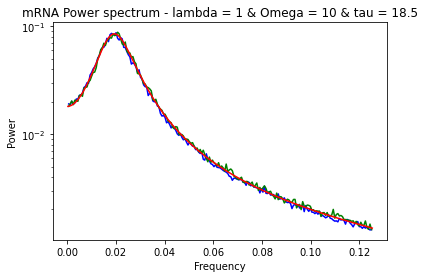

lambda= 1
Omega= 10
tau= 100


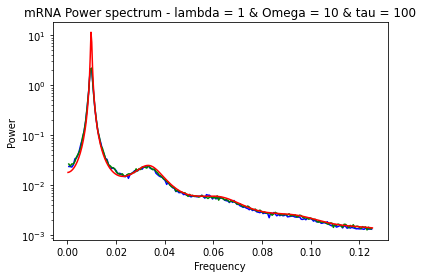

lambda= 1
Omega= 100
tau= 0.001


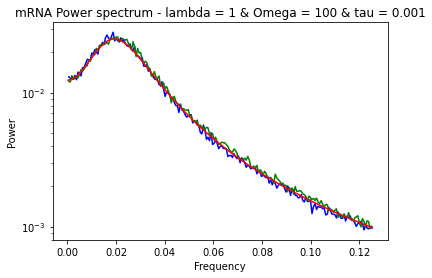

lambda= 1
Omega= 100
tau= 18.5


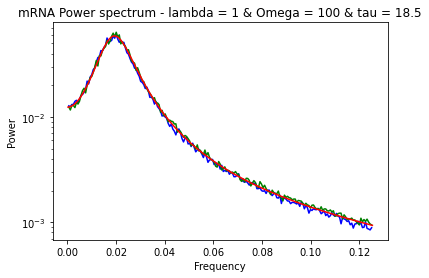

lambda= 1
Omega= 100
tau= 100


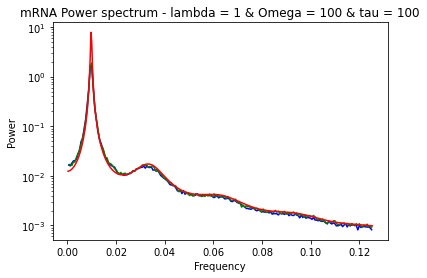

lambda= 10
Omega= 1
tau= 0.001


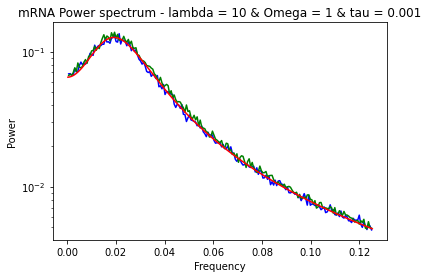

lambda= 10
Omega= 1
tau= 18.5


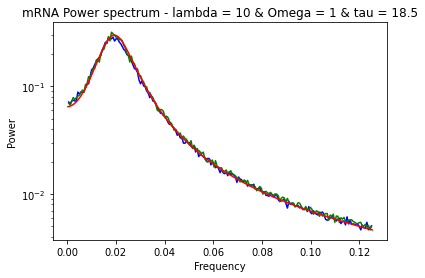

lambda= 10
Omega= 1
tau= 100


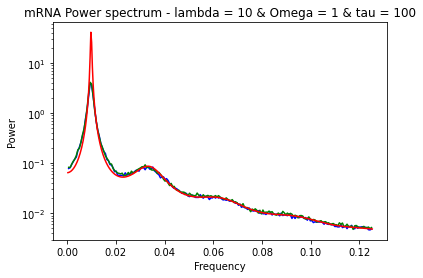

lambda= 10
Omega= 10
tau= 0.001


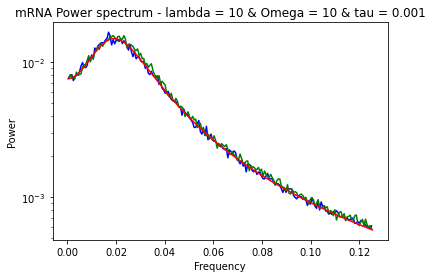

lambda= 10
Omega= 10
tau= 18.5


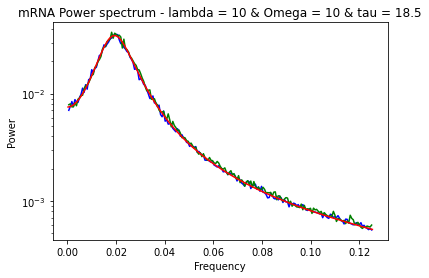

lambda= 10
Omega= 10
tau= 100


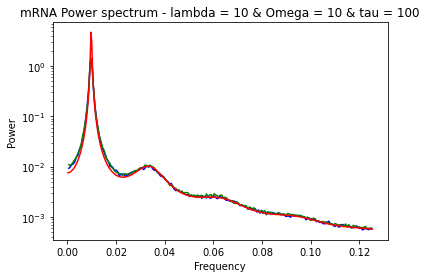

lambda= 10
Omega= 100
tau= 0.001


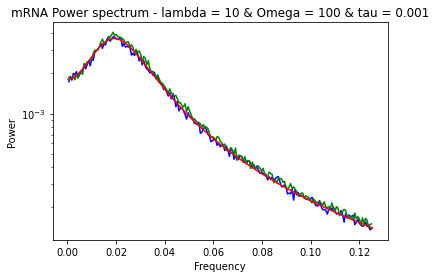

lambda= 10
Omega= 100
tau= 18.5


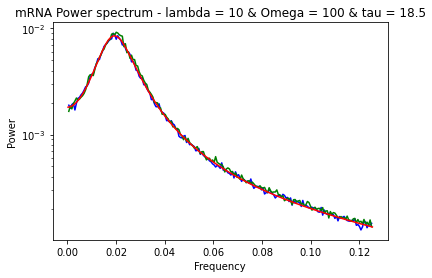

lambda= 10
Omega= 100
tau= 100


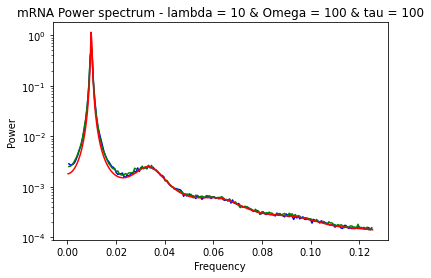

lambda= 100
Omega= 1
tau= 0.001


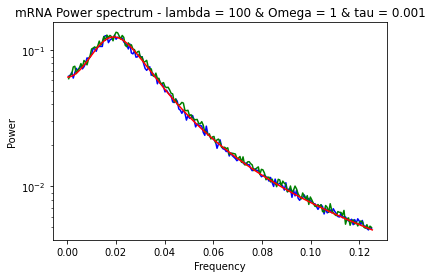

lambda= 100
Omega= 1
tau= 18.5


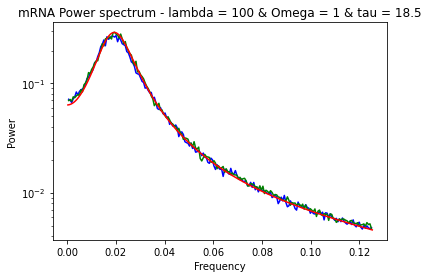

lambda= 100
Omega= 1
tau= 100


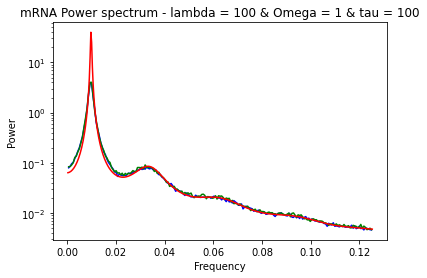

lambda= 100
Omega= 10
tau= 0.001


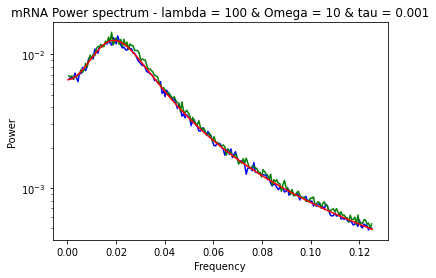

lambda= 100
Omega= 10
tau= 18.5


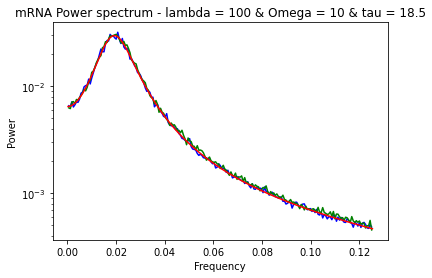

lambda= 100
Omega= 10
tau= 100


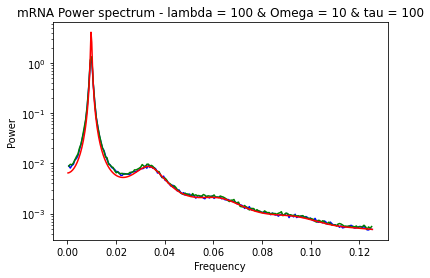

lambda= 100
Omega= 100
tau= 0.001


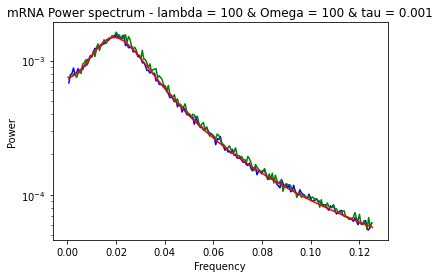

lambda= 100
Omega= 100
tau= 18.5


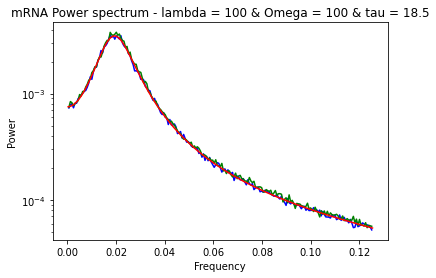

lambda= 100
Omega= 100
tau= 100


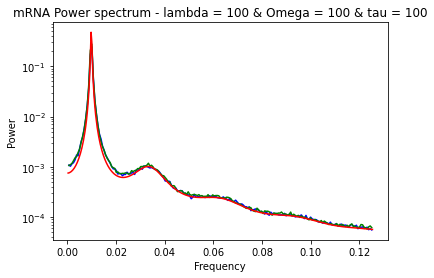

In [87]:
for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
        
            print('lambda=',val_lambda[i])    
            print('Omega=',val_Omega[j])
            print('tau=',val_tau[k])

            fig, ax1 = plt.subplots() 

            ax1.set_title('mRNA Power spectrum - lambda = ' + str(val_lambda[i]) + ' & Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
            ax1.set_xlabel('Frequency') 
            ax1.set_ylabel('Power') 

            omega_th,Sm,_=utils.lna_power_spectrum(h=h,lambda_s=val_lambda[i],P_0=1000,tau=val_tau[k],Omega=val_Omega[j],T=T,delta_t=1)
            
            ax1.plot(omega_th[1:200], power_spectrum_Mm[i,j,k][1:200], color = 'blue') 
            ax1.plot(omega_th[1:200], power_spectrum_Ml[i,j,k][1:200], color = 'green')
            ax1.plot(omega_th[1:400]/2, Sm[1:400], color = 'red')    
            
            ax1.tick_params(axis ='y') 
            ax1.set_yscale('log')        

            #ax1.set_xlim(0, 0.4)
            #ax1.set_ylim(1, 50)
            
            plt.savefig('plots/power_spectra_M/plot_power_spectrum_M - lambda' + str(val_lambda[i]) + 'and Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

            plt.show()

lambda= 0.01
Omega= 1
tau= 0.001


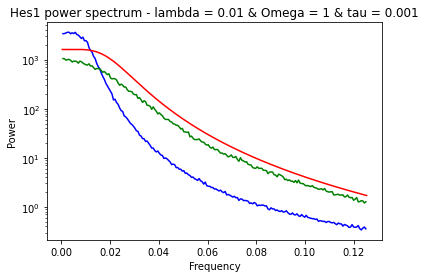

lambda= 0.01
Omega= 1
tau= 18.5


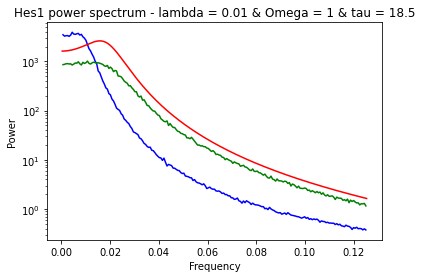

lambda= 0.01
Omega= 1
tau= 100


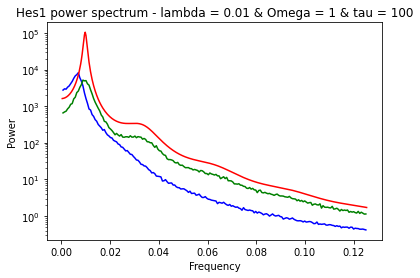

lambda= 0.01
Omega= 10
tau= 0.001


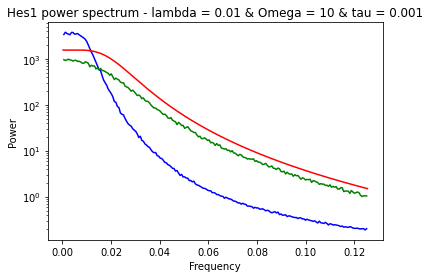

lambda= 0.01
Omega= 10
tau= 18.5


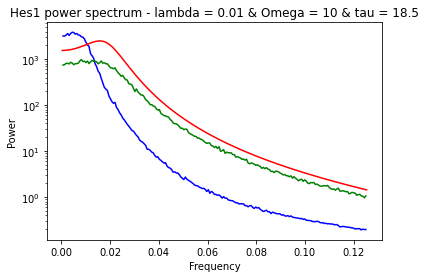

lambda= 0.01
Omega= 10
tau= 100


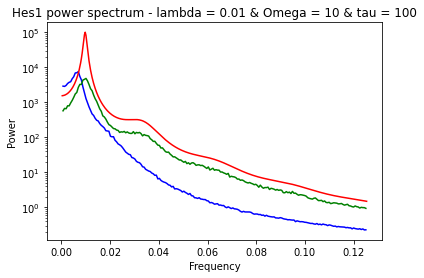

lambda= 0.01
Omega= 100
tau= 0.001


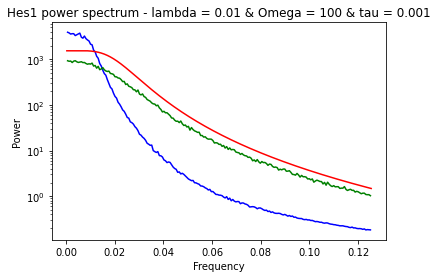

lambda= 0.01
Omega= 100
tau= 18.5


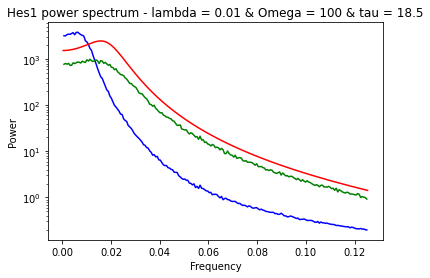

lambda= 0.01
Omega= 100
tau= 100


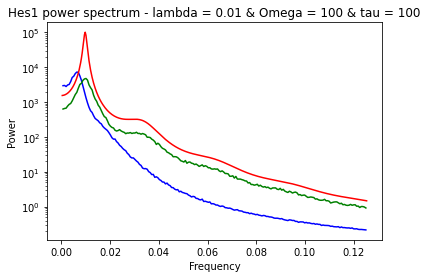

lambda= 0.1
Omega= 1
tau= 0.001


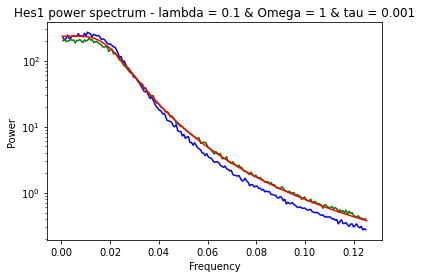

lambda= 0.1
Omega= 1
tau= 18.5


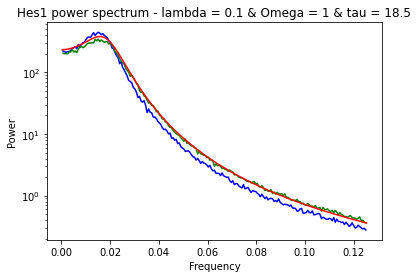

lambda= 0.1
Omega= 1
tau= 100


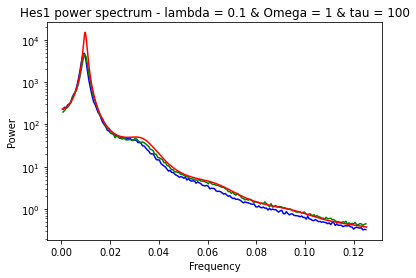

lambda= 0.1
Omega= 10
tau= 0.001


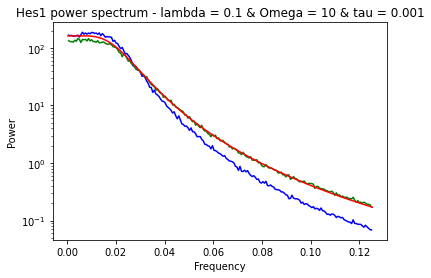

lambda= 0.1
Omega= 10
tau= 18.5


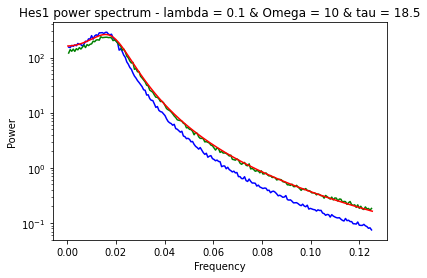

lambda= 0.1
Omega= 10
tau= 100


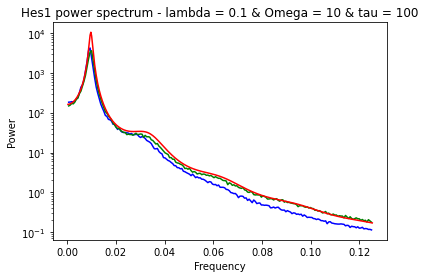

lambda= 0.1
Omega= 100
tau= 0.001


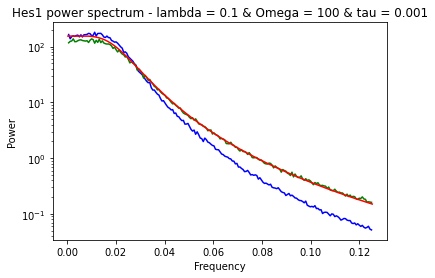

lambda= 0.1
Omega= 100
tau= 18.5


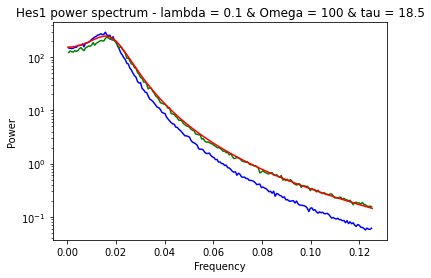

lambda= 0.1
Omega= 100
tau= 100


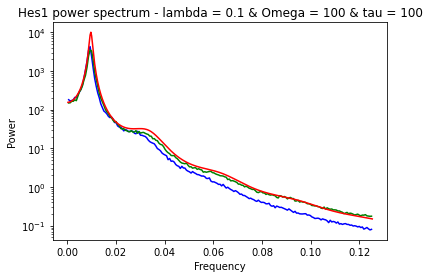

lambda= 1
Omega= 1
tau= 0.001


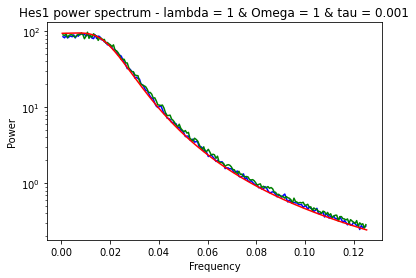

lambda= 1
Omega= 1
tau= 18.5


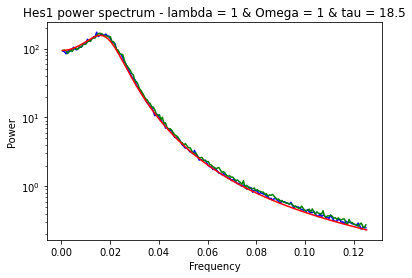

lambda= 1
Omega= 1
tau= 100


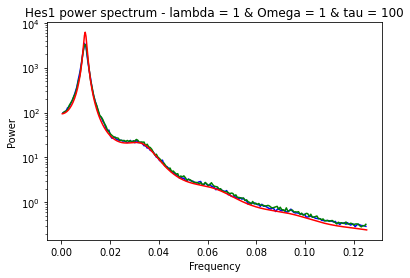

lambda= 1
Omega= 10
tau= 0.001


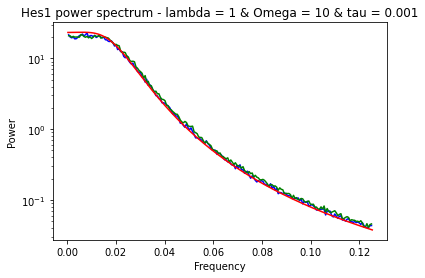

lambda= 1
Omega= 10
tau= 18.5


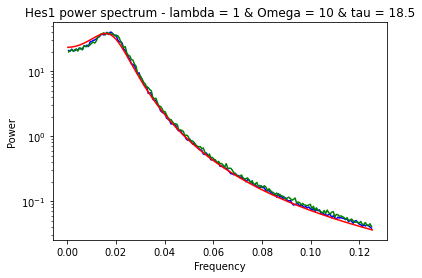

lambda= 1
Omega= 10
tau= 100


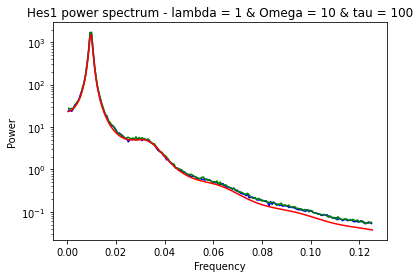

lambda= 1
Omega= 100
tau= 0.001


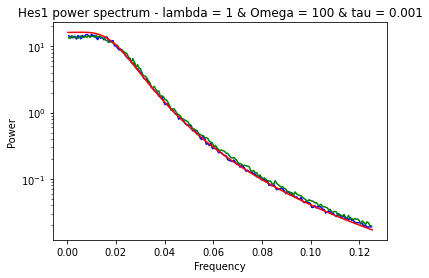

lambda= 1
Omega= 100
tau= 18.5


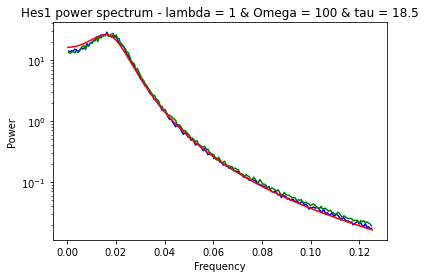

lambda= 1
Omega= 100
tau= 100


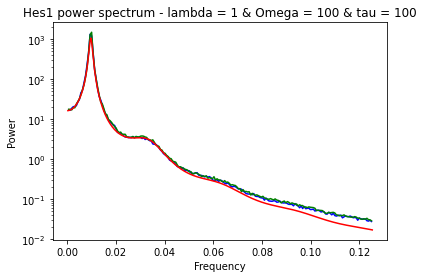

lambda= 10
Omega= 1
tau= 0.001


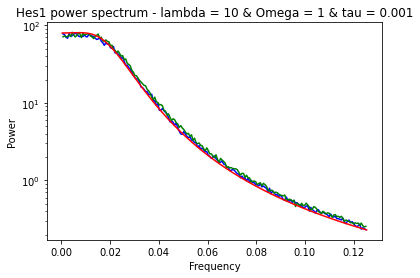

lambda= 10
Omega= 1
tau= 18.5


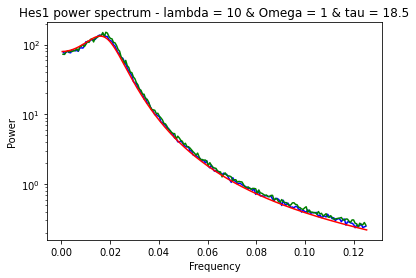

lambda= 10
Omega= 1
tau= 100


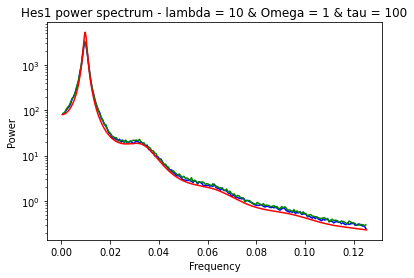

lambda= 10
Omega= 10
tau= 0.001


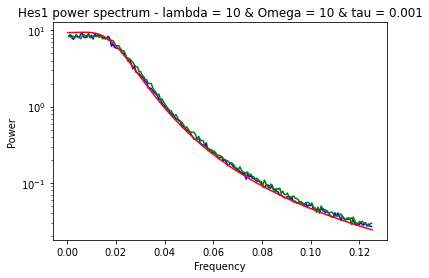

lambda= 10
Omega= 10
tau= 18.5


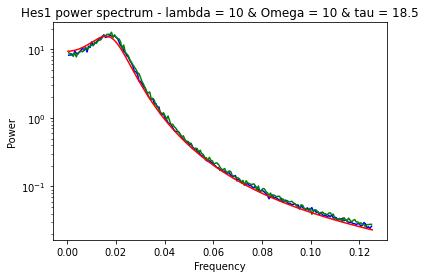

lambda= 10
Omega= 10
tau= 100


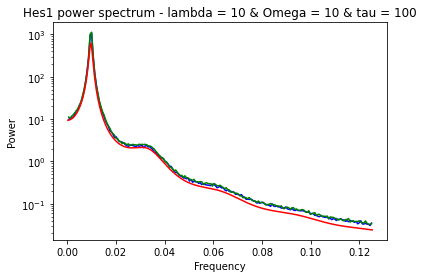

lambda= 10
Omega= 100
tau= 0.001


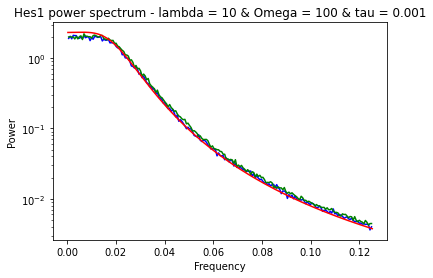

lambda= 10
Omega= 100
tau= 18.5


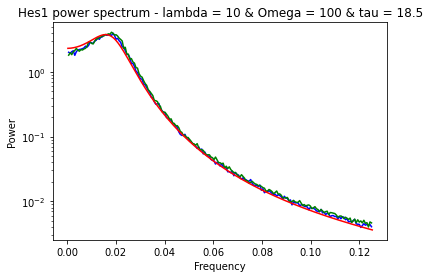

lambda= 10
Omega= 100
tau= 100


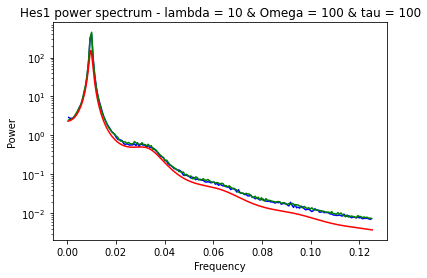

lambda= 100
Omega= 1
tau= 0.001


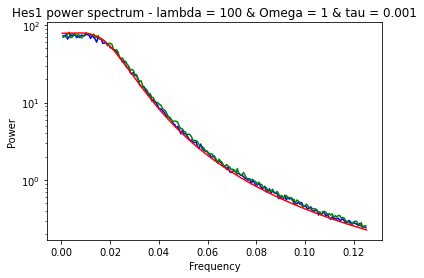

lambda= 100
Omega= 1
tau= 18.5


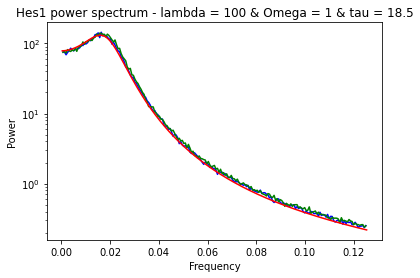

lambda= 100
Omega= 1
tau= 100


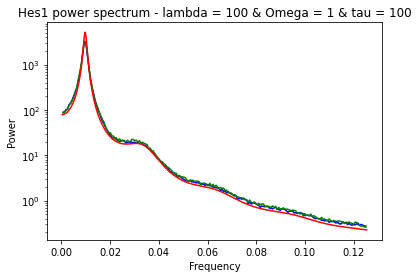

lambda= 100
Omega= 10
tau= 0.001


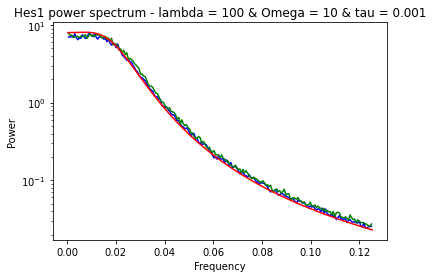

lambda= 100
Omega= 10
tau= 18.5


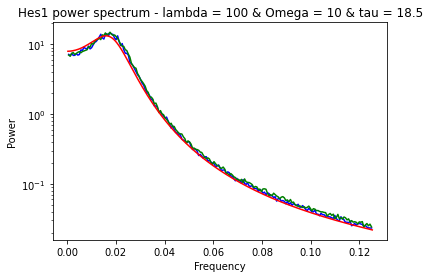

lambda= 100
Omega= 10
tau= 100


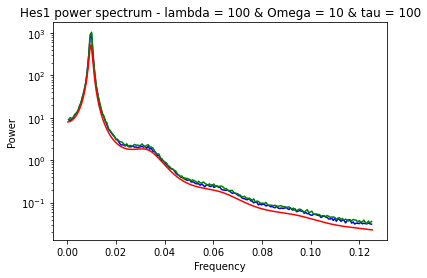

lambda= 100
Omega= 100
tau= 0.001


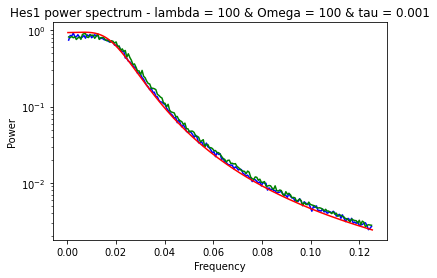

lambda= 100
Omega= 100
tau= 18.5


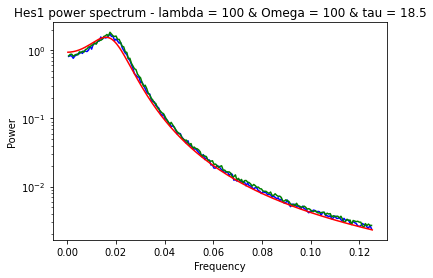

lambda= 100
Omega= 100
tau= 100


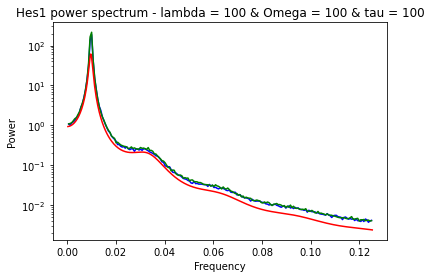

In [88]:
for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
        
            print('lambda=',val_lambda[i])    
            print('Omega=',val_Omega[j])
            print('tau=',val_tau[k])

            fig, ax1 = plt.subplots() 

            ax1.set_title('Hes1 power spectrum - lambda = ' + str(val_lambda[i]) + ' & Omega = ' +  str(val_Omega[j]) + ' & tau = ' + str(val_tau[k])) 
            ax1.set_xlabel('Frequency') 
            ax1.set_ylabel('Power') 

            omega_th,_,Sp=utils.lna_power_spectrum(lambda_s=val_lambda[i],P_0=1000,tau=val_tau[k],Omega=val_Omega[j],T=T,delta_t=1)
            
            ax1.plot(omega_th[1:200], power_spectrum_Pm[i,j,k][1:200], color = 'blue') 
            ax1.plot(omega_th[1:200], power_spectrum_Pl[i,j,k][1:200], color = 'green')
            ax1.plot(omega_th[1:400]/2, Sp[1:400], color = 'red')   

            ax1.tick_params(axis ='y') 
            ax1.set_yscale('log')        

            #ax1.set_xlim(-0.04, 0.04)
            #ax1.set_ylim(0.01, 1000000)
            
            plt.savefig('plots/power_spectra_P/plot_power_spectrum_P - lambda' + str(val_lambda[i]) + 'and Omega' +  str(val_Omega[j]) + ' and tau' + str(val_tau[k]) + '.pdf')  

            plt.show()

### Computation time

In [55]:
times_m=np.zeros((n_lambda,n_Omega,n_tau))
times_l=np.zeros((n_lambda,n_Omega,n_tau))


for i in range(n_lambda):
    for j in range(n_Omega):
        for k in range(n_tau):
            t0=time.time()
            
            tm,Mm,Pm=master.one_trajectory(tau=val_tau[k],lambda_s=val_lambda[i],Omega=val_Omega[j],P_0=1000,T=10000)
            t1=time.time()
            
            tl,Ml,Pl=langevin.one_trajectory(tau=val_tau[k],lambda_s=val_lambda[i],Omega=val_Omega[j],P_0=1000,T=10000)
            t2=time.time()
            
            times_m[i,j,k] = t1-t0
            times_l[i,j,k] = t2-t1

In [57]:
pd.DataFrame(times_l/times_m,columns=['value']).to_csv('output/data/computation_times.csv')

array([[[8.27556987e-02, 1.38036209e-02, 4.29884595e-01],
        [1.61621549e-03, 1.31564050e-03, 1.23784502e-03],
        [1.31821973e-04, 1.15241647e-04, 2.16549247e-04]],

       [[5.99058805e-03, 1.20962351e-02, 2.66645900e-02],
        [2.45904290e-03, 1.16238689e-03, 3.68872868e-03],
        [2.41627457e-04, 2.30193481e-04, 1.10531523e-04]],

       [[2.73779000e-01, 2.50114718e-02, 4.55432855e-01],
        [2.37522286e-03, 2.35586307e-03, 1.25454024e-03],
        [2.42585242e-04, 1.16201257e-04, 1.09139007e-04]],

       [[1.20503380e-02, 1.05231992e-02, 1.13629900e-02],
        [2.37460229e-03, 1.16940708e-03, 2.33368548e-03],
        [2.44240054e-04, 1.14612092e-04, 1.06604805e-04]],

       [[4.27222443e-03, 1.14044670e-02, 1.16401762e-02],
        [1.12559076e-03, 1.09642732e-03, 1.09914537e-03],
        [2.41281260e-04, 1.14590917e-04, 1.05894985e-04]]])